In [1]:
import os
import sys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gp
import shapely
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize
import seaborn as sns
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import load_npz
import time
import itertools
from itertools import combinations
import random
import copy
import math

sys.path.append("../../wave_cluster")
import wave_cluster as wc
#import wavefinder
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'wave_cluster'

### Import data

In [2]:
# Import indexing and related demographic data
index = pd.read_csv("../data/index.csv", index_col = 0)
demographics = pd.read_csv("../data/demographics.csv", index_col = 0)

# US state-level daily case data (# new cases every day)
# Dropping the first 39 timestamps during which reporting practices were still being developed
# and dropping a few of the territories with irregular data
data = pd.read_csv("../data/us_state_daily.csv", index_col = 0)
data = data.iloc[39:,:]
dr = ['US_VI', 'US_MP', 'US_GU', 'US_AS', 'US_DC']
data = data.drop(dr, axis = 1)


# Normalization of each location's time-series to be cases per 100,000 persons (typical in the literature)
population = demographics.loc[data.columns,"population"]
norm_data = data.apply(lambda x: x/population[x.name])
data = norm_data * 100000 # cases per 100,000


# Windowed average smoothing of each time-series 
# Using 7 day average with 3 days in front and behind burrent time-stamp
front = 7
back = 7

# Double averaging procedure (gets rid of sharp fluctuations)
smooth_data = wc.window_average(data.to_numpy(), front = front, back = back)
smooth_data = wc.window_average(smooth_data, front = front, back = back)
smooth_data = wc.window_average(smooth_data, front = front, back = back)
smoothed_index = data.index[front*3:-back*3]
data = pd.DataFrame(smooth_data, index = smoothed_index, columns = data.columns)

# remove any negative entries (reporting errors still present after smoothing)
data[data < 0] = 0

str_index = data.index
data.index = pd.to_datetime(data.index)
locations = data.columns

In [3]:
# Geographic information -- containing coordinates for each state's center of population
state_centers = pd.read_csv("../data/state_centers.csv", index_col = 0)
state_centers_dict = {i: np.array(state_centers.loc[state_centers.STNAME == i].iloc[:,1:]).flatten() for i in state_centers.STNAME.values}

# Government response / containment health data
containment_health = pd.read_csv('../data/state_containment_health.csv', index_col = 0)
containment_health = containment_health.loc[str_index,:]
containment_health = containment_health.loc[:, data.columns]
containment_health.index = pd.to_datetime(containment_health.index)

# Precomputed segmentation matrices for each of our segmentation methods
# (To compute these use the segmentation scripts from data/batch)
sir_cuts = pd.read_csv('../batch/state/data/sir_cuts.csv', index_col = 0)
unimodal_cuts = pd.read_csv("../batch/state/data/unimodal_cuts.csv", index_col = 0)
unimodal_cuts = unimodal_cuts.iloc[::2,:]
wavefinder_cuts = pd.read_csv("../batch/state/data/wav_cuts.csv", index_col = 0)

# For those precomputed segmentations, we also have pre-computed 
# pairwise distance matrices giving the distance between wave segments
D_sir = load_npz('../batch/state/data/sir_pairwise.npz')
D_uni = load_npz('../batch/state/data/unimodal_pairwise.npz')
D_wav = load_npz('../batch/state/data/wav_pairwise.npz')

# Create wave pool objects from the segmentations
wpool_sir = wc.wave_pool(data, sir_cuts[data.columns])
wpool_uni = wc.wave_pool(data, unimodal_cuts[data.columns])
wpool_wav = wc.wave_pool(data, wavefinder_cuts[data.columns])

# This is a wrapper distance function that I use to 
# compute pairwise distances in miles between segments
def miles_dist(loc1, loc2):
    loc1 = loc1[:loc1.rfind('_')]
    loc2 = loc2[:loc2.rfind('_')]
    x_loc = state_centers_dict[loc1]
    y_loc = state_centers_dict[loc2]
    return wc.haversine(x_loc, y_loc)

# Here we create similar distance matrices between segments, but this 
# time using distance in miles.
D_uni_miles = wc.pairwise_from_pool(wpool_uni, miles_dist)
D_sir_miles = wc.pairwise_from_pool(wpool_sir, miles_dist)
D_wav_miles = wc.pairwise_from_pool(wpool_sir, miles_dist)

# Finally, we also include pairwise distances between each wave segments corresponding 
# government response time series. More specifically, the government response data is time 
# series data with the same shape as our infection data. We can use the same segmentations to 
# find public health response 'waves' and then compute pairwise distances between them.
D_uni_health = load_npz('../batch/state/data/unimodal_pairwise_health.npz')
D_sir_health = load_npz('../batch/state/data/sir_pairwise_health.npz')
D_wav_health = load_npz('../batch/state/data/wav_pairwise_health.npz')

### Map visualization

In [4]:
pd.set_option('mode.chained_assignment', None)

smap1 = sns.color_palette("tab20b", 30)
cmap1 = LinearSegmentedColormap.from_list('mymap1', smap1, N=20)

smap2 = sns.color_palette("tab20b", 19)[2:]
cmap2 = LinearSegmentedColormap.from_list('mymap2', smap2, N=4)

# json file with geographic info for each state -- required for graphing
state_map = gp.read_file("../data/visualization/tl_rd22_us_state/tl_rd22_us_state.shp")
sl = ['United States Virgin Islands', 'Commonwealth of the Northern Mariana Islands', 'Guam', 'American Samoa'] 
state_map = state_map.drop(state_map.loc[state_map.NAME.isin(sl)].index, axis = 0)
state_map.index = range(len(state_map))

In [5]:
adjusts = {'Hawaii': [40,2.5,0.75],'Puerto Rico': [-5,3,1.5], 'Alaska': [-95,-15,0.25]}

for a in adjusts.keys():
    g = state_map.loc[state_map.NAME == a]
    tr = adjusts[a]
    g['geometry'] = g['geometry'].apply(lambda x:shapely.affinity.scale(x, xfact=tr[2], yfact=tr[2]))
    g['geometry'] = g['geometry'].apply(lambda x:shapely.affinity.translate(x, xoff=tr[0], yoff=tr[1]))
    state_map.loc[state_map.NAME == a] = g

(20.0, 52.0)

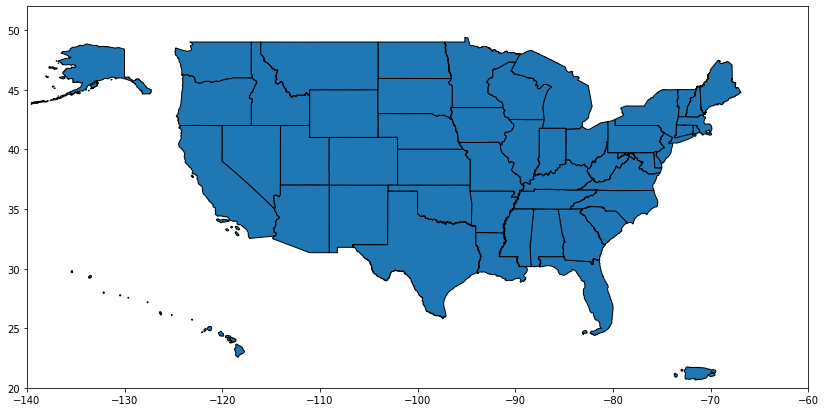

In [6]:
fig,ax = plt.subplots(figsize = (14,8))
state_map.plot(ax = ax, edgecolor="black")
ax.set_xlim(-140, -60)
ax.set_ylim(20,52)

In [7]:
translator = {'US_AK': 'Alaska', 'US_AL':'Alabama', 'US_AR':'Arkansas', 'US_AZ':'Arizona', 'US_CA':'California',
             'US_CO':'Colorado', 'US_CT':'Connecticut', 'US_DC':'District of Columbia', 'US_DE':'Delaware', 
             'US_FL':'Florida', 'US_GA':'Georgia', 'US_HI':'Hawaii', 'US_IA': 'Iowa', 'US_ID':'Idaho',
             'US_IL':'Illinois', 'US_IN':'Indiana', 'US_KS':'Kansas', 'US_KY':'Kentucky', 'US_LA':'Louisiana',
             'US_MA':'Massachusetts', 'US_MD':'Maryland', 'US_ME':'Maine', 'US_MI':'Michigan', 'US_MN':'Minnesota',
             'US_MO':'Missouri', 'US_MS':'Mississippi', 'US_MT':'Montana', 'US_NC':'North Carolina', 'US_ND':'North Dakota',
             'US_NE':'Nebraska', 'US_NH':'New Hampshire', 'US_NJ':'New Jersey', 'US_NM':'New Mexico', 'US_NV':'Nevada',
             'US_NY':'New York', 'US_OH':'Ohio', 'US_OK':'Oklahoma', 'US_OR':'Oregon', 'US_PA':'Pennsylvania', 
             'US_PR':'Puerto Rico', 'US_RI':'Rhode Island', 'US_SC':'South Carolina', 'US_SD':'South Dakota',
             'US_TN':'Tennessee', 'US_TX':'Texas', 'US_UT':'Utah', 'US_VA':'Virginia', 'US_VT':'Vermont', 'US_WA':'Washington',
             'US_WI':'Wisconsin', 'US_WV':'West Virginia', 'US_WY':'Wyoming'}

## Segmentation

In [8]:
# For a single location we can visualize the differences between 
# each of our segmentation methods
location = 'US_LA'
sir_segment = sir_cuts.loc[:,location].to_numpy()
sir_segment = sir_segment[~np.isnan(sir_segment)]
unimodal_segment = unimodal_cuts.loc[:,location].to_numpy()
unimodal_segment = unimodal_segment[~np.isnan(unimodal_segment)]
wav_segment = wavefinder_cuts.loc[:,location].to_numpy()
wav_segment = wav_segment[~np.isnan(wav_segment)]

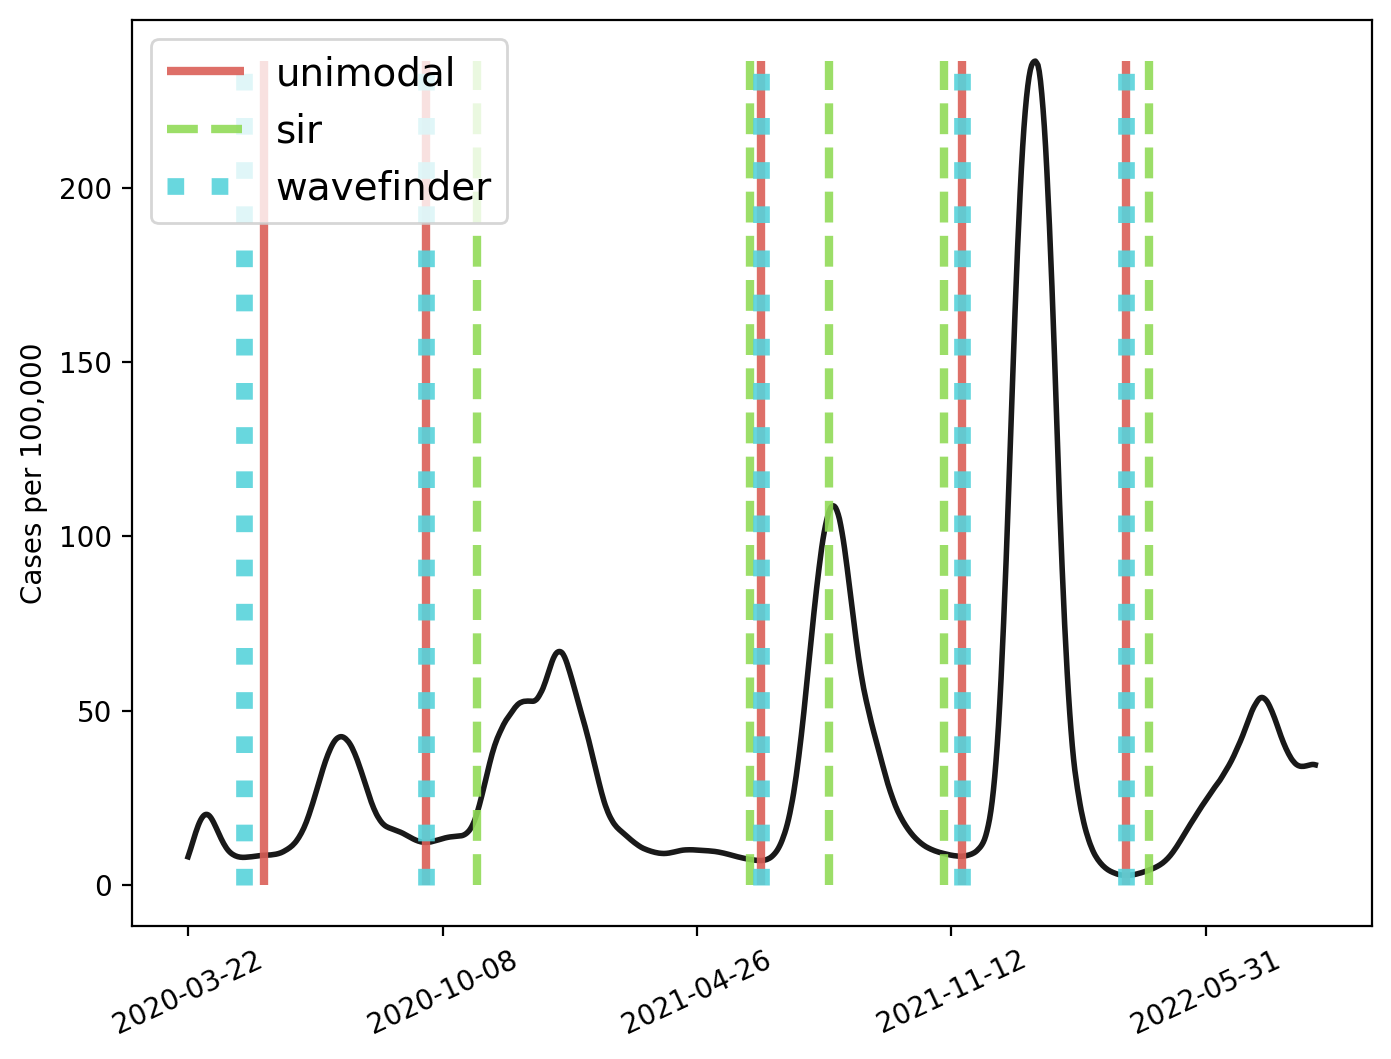

In [9]:
fig,ax = plt.subplots(1,1,figsize = (8,6), dpi = 200)
ax.plot(data.loc[:,location].to_numpy(), color = 'k', alpha = 0.9, linewidth = 2)
pal = sns.color_palette("hls", 8)
plt.rcParams.update({'font.size': 14})


for c in range(1,len(unimodal_segment)-1):
    if c == 1:
        ax.vlines(unimodal_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[0], linestyle = '-', alpha = 0.9, label = 'unimodal', linewidth = 3)
    else:
        ax.vlines(unimodal_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[0], linestyle = '-', alpha = 0.9, linewidth = 3)
        
        
for c in range(1,len(sir_segment)-1):
    if c == 1:
        ax.vlines(sir_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[2], linestyle = '--', alpha = 0.9, label = 'sir', linewidth = 3)
    else:
        ax.vlines(sir_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[2], linestyle = '--', alpha = 0.9, linewidth = 3)
        
        

for c in range(1,len(wav_segment)-1):
    if c == 1:
        ax.vlines(wav_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[4], linestyle = 'dotted', alpha = 0.9, label = 'wavefinder', linewidth = 6)
    else:
        ax.vlines(wav_segment[c], ymin = 0, ymax = np.max(data.loc[:,location]), color = pal[4], linestyle = 'dotted', alpha = 0.9, linewidth = 6)
        
plt.xticks(ticks=[0, 200, 400, 600, 800], labels=[str(data.index[0])[:10], str(data.index[200])[:10], str(data.index[400])[:10], 
                                                  str(data.index[600])[:10], str(data.index[800])[:10]])

plt.ylabel('Cases per 100,000')
plt.xticks(rotation=25) 
plt.legend()

In [10]:
# To be more rigorous, we compute segmentation disagreement distances between pairs of the methods. 
# The function compute_disagreements takes two segmentation dataframe (which must have the same columns)
# and returns a vector of disagreement distances between each of the corresponding columns. 
disagreements1 = wc.compute_disagreements(sir_cuts, unimodal_cuts)
disagreements2 = wc.compute_disagreements(wavefinder_cuts, unimodal_cuts)
disagreements3 = wc.compute_disagreements(sir_cuts, wavefinder_cuts)

In [43]:
# I also use _random_segment.py to generate random segmentation 
# dataframes -- these will be uesful to compare against
def get_random_segments():
    max_segments = 10
    segment_size = 60

    rand_cuts = np.zeros((max_segments + 1, len(locations)))

    # For each location make a random segmentation
    for l in range(len(locations)):
        loc = locations[l]
        vec = data.loc[:,loc].to_numpy()

        ucuts = unimodal_cuts.loc[:,loc].to_numpy()
        chosen_segs = int((len(ucuts[~np.isnan(ucuts)]) - 1))
        
        rand_seg = wc.random_segment(vec, chosen_segs, segment_size)
        rcuts = rand_seg.generate()

        rand_cuts[:len(rcuts),l] = rcuts
        
    # And then place it into a dataframe
    rand_cuts = pd.DataFrame(rand_cuts, columns = locations)
    rand_cuts.replace(0, np.nan, inplace=True)
    rand_cuts.iloc[0,:] = np.zeros(rand_cuts.shape[1])
    return rand_cuts

In [45]:
# For a number of samples, I'll also then compute the 
# disagreement distance between the random segmentations and 
# our unimodal segmentations
samples = 10000
disagreements4 = np.zeros((samples, len(locations)))

for s in range(samples):
    rand_cuts = get_random_segments()
    disagreements4[s,:] = wc.compute_disagreements(rand_cuts, unimodal_cuts)

# Then just going to take the mean of the disagreements
avg_disagreements = np.mean(disagreements4, axis = 0)

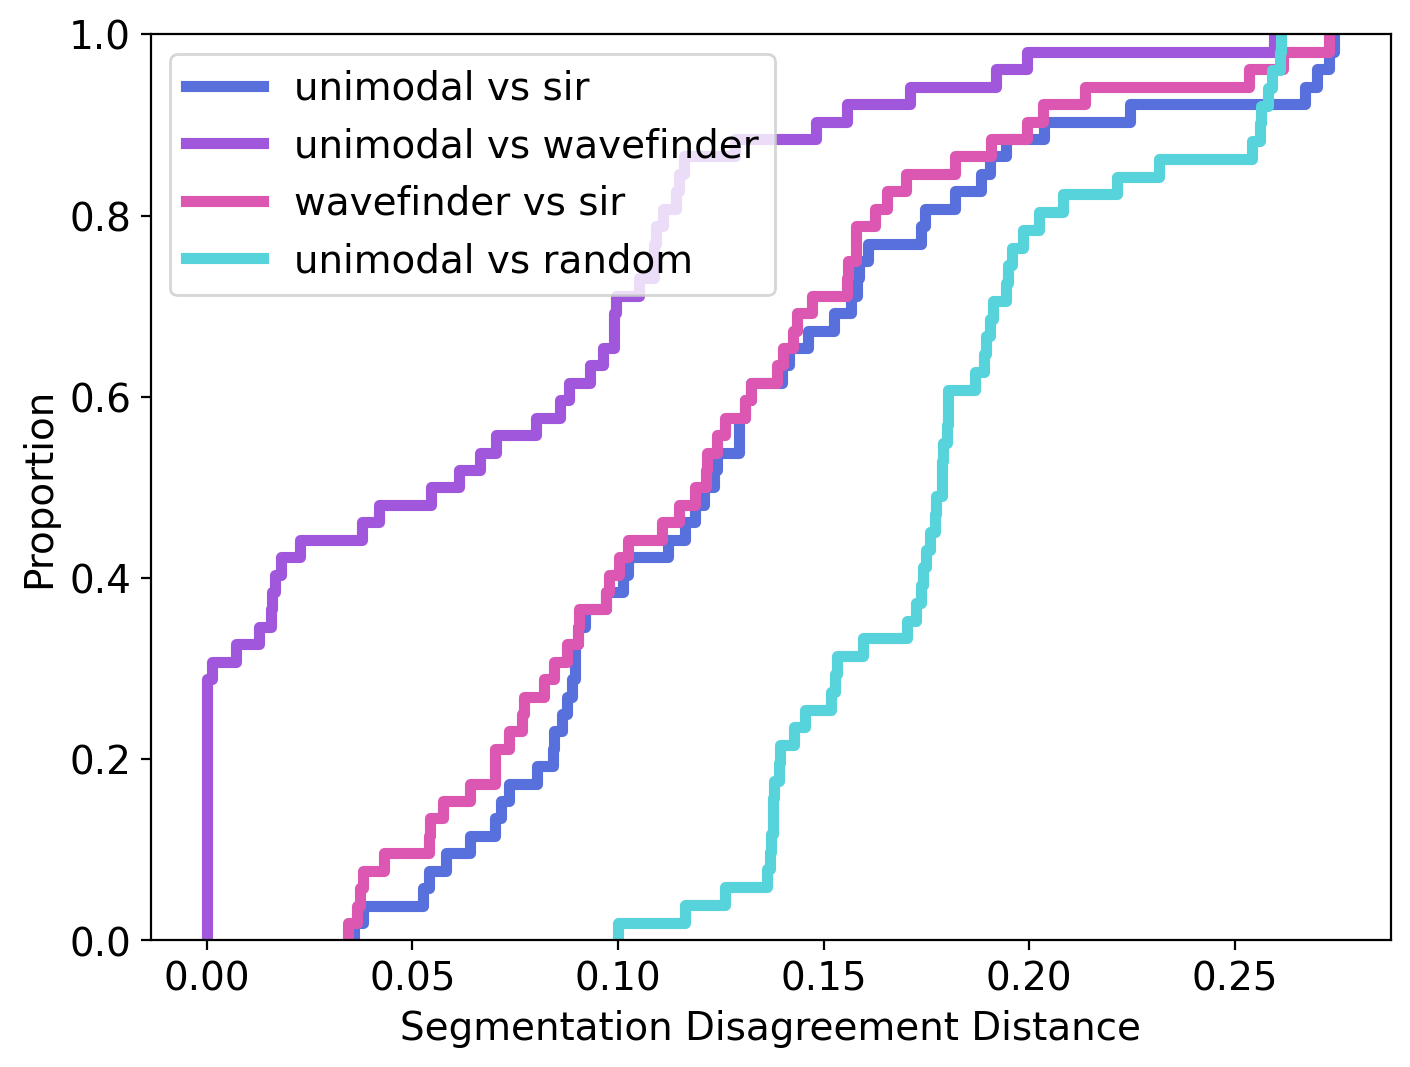

In [46]:
# visualize the results
fig,ax = plt.subplots(figsize = (8,6), dpi = 200)
pal = sns.color_palette("hls", 8)
plt.rcParams.update({'font.size': 14})

sns.ecdfplot(disagreements1, color = pal[5], linewidth = 4, stat = 'proportion', label = 'unimodal vs sir')
sns.ecdfplot(disagreements2, color = pal[6], linewidth = 4, stat = 'proportion', label = 'unimodal vs wavefinder')
sns.ecdfplot(disagreements3, color = pal[7], linewidth = 4, stat = 'proportion',linestyle='-', label = 'wavefinder vs sir')

cc = sns.ecdfplot(avg_disagreements, color = pal[4], linewidth = 4, stat = 'proportion',linestyle='-', label = 'unimodal vs random')
ax.set_xlabel('Segmentation Disagreement Distance')

plt.legend()

In [113]:
peaks = []
peak_times = []
response_vals = []
for seg in wpool.key_list:
    seg_times = wpool.times[seg]
    data_vec = data.loc[:,seg[:seg.rfind('_')]][seg_times[0]:seg_times[1]]
    response_vec = containment_health.loc[:,seg[:seg.rfind('_')]][seg_times[0]:seg_times[1]]
    peaks.append(data_vec.max())
    peak_times.append(data_vec.index[data_vec.argmax()])
    response_vals.append(response_vec.mean())

Text(0, 0.5, 'Peak Infection')

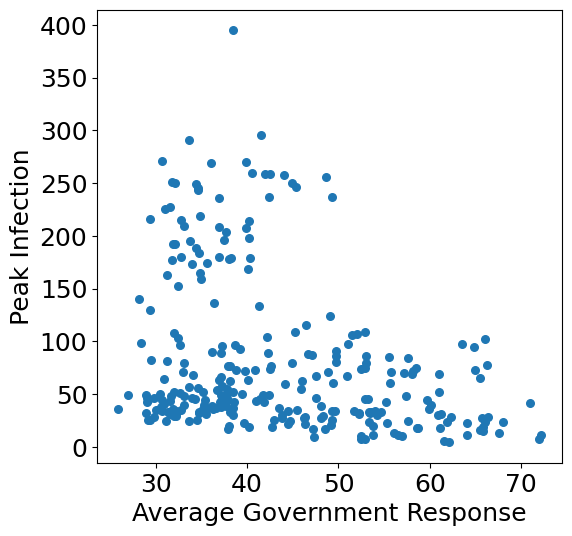

In [116]:
fig,ax = plt.subplots(figsize = (6,6), dpi = 100)

ax.scatter(response_vals, peaks, marker = 'o', s = 30)
    
ax.set_xlabel('Average Government Response')
ax.set_ylabel('Peak Infection')

Text(0, 0.5, 'Peak Infection')

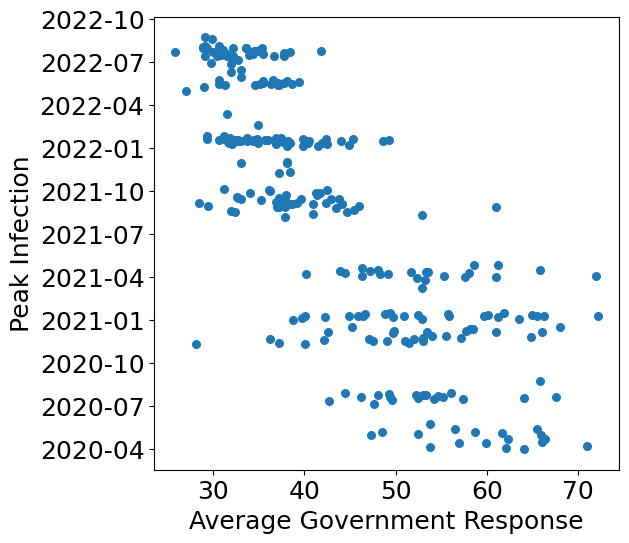

In [117]:
fig,ax = plt.subplots(figsize = (6,6), dpi = 100)

ax.scatter(response_vals, peak_times, marker = 'o', s = 30)
    
ax.set_xlabel('Average Government Response')
ax.set_ylabel('Peak Infection')

## Choosing Parameters

In [11]:
# Next we've pre-computed some stats on each of our clustering methods at different parameter values
# These should give us an idea for which parameter values we might be interested in
param_info = pd.read_csv('../batch/state/data/parameter_info.csv', index_col = 0)
param_info.overlap = np.round(param_info.overlap, 3)
param_info = param_info.loc[param_info.overlap != 1]

# This is the grid of parameter we tested over
percent_try = np.round(np.linspace(0.1,1,37),3)[:-1]
threshold_try = np.round(np.linspace(0,0.5,101),3)

# Making the choice to only consider options with overlap >= 0.5 which seems reasonable
# and threshold <= 0.25 because most of results past this point seem to have bad silhouette scores
percent_try = percent_try[percent_try >= 0.5]
threshold_try = threshold_try[threshold_try <= 0.25]

In [12]:
# Choose a specific clustering method to analyze its results
method = 'uni'

# next I'm just taking the output results and putting them into a readable form
method_param_info = param_info.loc[param_info.method == method]
pcombs = method_param_info.loc[:,['overlap', 'threshold']].value_counts().index
method_param_averages = []
samps = method_param_info['sample'].value_counts().index

# For each parameter combination
for p in pcombs:
    ploc = method_param_info[(method_param_info['overlap'] == p[0]) & (method_param_info['threshold'] == p[1])]
    
    # Every individual cluster has a silhouette score which is normalized by the number of 
    # locations within the cluster. This un-normalizes and computes the global average over all of the clusters. 
    total_size = np.sum(ploc.loc[:, 'cluster_size'])
    if total_size != 0:
        score_mean = np.sum((ploc.loc[:,'silhouette'] * ploc.loc[:, 'cluster_size']))/ total_size
    else:
        score_mean = 0
    method_param_averages.append([p[0], p[1], score_mean])
        
# Put all this information into a more succinct data frame
method_param_averages = pd.DataFrame(method_param_averages, columns = ['overlap', 'threshold', 'silhouette'])
method_param_averages.overlap = np.round(method_param_averages.overlap, 3)
method_param_averages.threshold = np.round(method_param_averages.threshold, 3)

In [13]:
# and then transform it into a matrix for visualization:
var = 'silhouette'
param = method_param_averages
param_matrix = np.zeros((len(threshold_try), len(percent_try) - 1))
for t in range(len(threshold_try)):
    thrsh = param.loc[param.threshold == threshold_try[t]]
    for p in range(len(percent_try) - 1):
        try:
            prcnt = thrsh.loc[thrsh.overlap == percent_try[p]]
            param_matrix[t,p] = prcnt[var]
        except:
            print((p,t))

Text(0.5, 1.0, 'silhouette score')

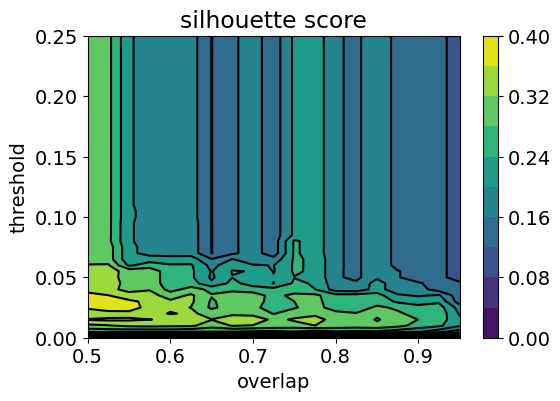

In [14]:
fig, ax = plt.subplots(dpi = 100)
cs = ax.contourf(percent_try[:-1], threshold_try, param_matrix, levels = 10)
ax.contour(cs, colors='k')
cbar = fig.colorbar(cs)
ax.set_xlabel('overlap')
ax.set_ylabel('threshold')
ax.set_title('silhouette score')

In [15]:
# Our strategy for selecting parameter values is to just take the combination 
# that gives the largest average silhouetter score
param.loc[param.overlap >= 0.5].sort_values(by = 'silhouette', ascending = False)

,overlap,threshold,silhouette
872,0.525,0.025,0.388064
896,0.525,0.030,0.386623
866,0.550,0.025,0.381643
1084,0.500,0.030,0.376366
1110,0.500,0.035,0.373335
...,...,...,...
32,0.675,0.000,0.000000
33,0.650,0.000,0.000000
35,0.550,0.000,0.000000
9,0.575,0.000,0.000000


In [16]:
# Here are the (overlap, threshold) values giving the best average silhouette scores
# that we were able to find for each of the segmentation methods: 
# Unimodal: (0.525, 0.025)
# SIR: (0.6, 0.02)
# WAV: (0.575, 0.02)

## Clique Clustering

In [17]:
# Specify the wave pool object and the distance matrix to use 
# for clustering
wpool = wpool_uni
D = D_uni

# And the chosen overlap and threshold parameters:
overlap = 0.525
threshold = 0.025

# Then I'm also just going specify the other geographic and government 
# response distance matrices that we'll use for analysis.
dist_mats = [D_uni_miles, D_uni_health]

# With all of that defined, we can compute the list of edges between 
# segments which satisfy the overlap parameter
edge_list = wc.overlap_graph(overlap, wpool)

# And then create the clustering object!
cliquer = wc.clique_cluster(D, edge_list, linkage = 'complete', threshold = threshold)

# We always ask for 1 cluster, just to run the algorithm to its completion
# it may not actually be able to find a single cluster because of clique constraints
# we usually just take the minimum number of clusters that it finds as our final result.
cliquer.cluster(1)

In [18]:
# Once that's done we can set up the results for analysis
cluster_analysis = wc.cluster_analyze(cliquer, segment_pool = wpool)

# list of lists where each sublist is a cluster. The elements in each 
# list is an index to one of the wave segments in the data (more said below)
clustering = cluster_analysis.clustering

# cluster labels for each of the wave segments
labels = cluster_analysis.labels

# cluster data computation
cluster_data = wc.auxiliary_info(cliquer, wpool, dist_mats, containment_health, data)
cluster_data = pd.DataFrame(cluster_data, columns = ['cluster','cluster_size', 'cost','total_points','explained_variance',
                                                     'silhouette', 'geo_silhouette', 'health_silhouette',
                                                     'geo_pairwise', 'health_pairwise',
                                                     'containment_health','avg_infections'])
cluster_data_nons = cluster_data.loc[cluster_data.cluster_size > 1]

In [19]:
# NOTE: When you go to look at clustering, labels, or edge list you'll notice that 
# everything is indexed with integers. I.e. a cluster looks like [0,10,28] indicating that 
# wave segments 0, 10, and, 28 belong to a cluster. Each of these indices corresponds to a 
# a wave segment from the original data, and you can find out which by querying wpool.key_list[i]

In [20]:
# Also helpful is this dictionary I put together. Here you can take a 
# wave segment index i, and query cluster_waves[i] to see the time series associated 
# with that wave segment.
cluster_waves = {}
for clust in range(len(cliquer.C)):
    time_overlap_min = -1
    time_overlap_max = np.inf
    data_names = []
    for l in cliquer.C[clust]:
        lname = wpool.key_list[l]
        data_names.append(lname[:5])
        ltimes = wpool.times[lname]
        if ltimes[0] > time_overlap_min:
            time_overlap_min = ltimes[0]
        if ltimes[1] < time_overlap_max:
            time_overlap_max = ltimes[1]
            
        
    cluster_wave_data = data.loc[:, data_names].copy(deep = True)
    cluster_wave_data.iloc[:time_overlap_min,:] = np.nan
    cluster_wave_data.iloc[time_overlap_max:,:] = np.nan
    cluster_waves[clust] = cluster_wave_data

In [21]:
# Since there are often many too many clusters to go through individually, 
# we were very interested in selecting the most 'important' ones.
# To do so we look for clusters which either have the most points or explain the most amount 
# of variance in the data, relative to their cost
cluster_data_nons['point_cost'] = cluster_data_nons['total_points']/cluster_data_nons['cost']
cluster_data_nons['variance_cost'] = cluster_data_nons['explained_variance']/cluster_data_nons['cost']

In [22]:
# Here I greedily select the clusters that cover the most data points and will plot how the total 
# percent of data points covered changes as I select more and more clusters
point_cdf = cluster_data.sort_values(by = 'total_points', ascending = False).total_points.to_numpy()
point_cdf = point_cdf / (data.shape[0]*data.shape[1])

# Likewise I'm also finding the clusters which explain the most amount of variance in the data and will 
# plot how the percent of explained variance changes
var_cdf = cluster_data.sort_values(by = 'explained_variance', ascending = False).explained_variance.to_numpy()
X = data.to_numpy()
X = X - np.mean(X, axis = 0)
X = X ** 2
var_cdf = var_cdf / np.sum(X)

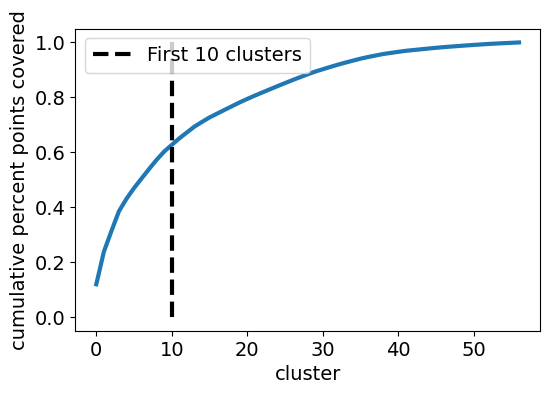

In [23]:
fig,ax = plt.subplots(dpi = 100)
ax.plot(np.cumsum(point_cdf), linewidth = 3)
ax.set_xlabel('cluster')
ax.set_ylabel('cumulative percent points covered')
ax.vlines(x = 10, ymin = 0, ymax = np.max(np.cumsum(point_cdf)), linestyle = '--', color = 'k', linewidth = 3, label = 'First 10 clusters')
plt.legend()

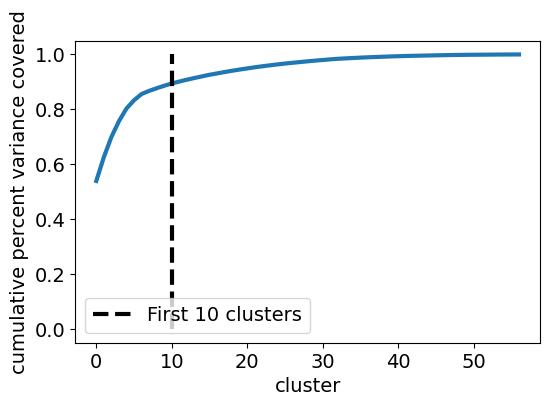

In [24]:
fig,ax = plt.subplots(dpi = 100)
ax.plot(np.cumsum(var_cdf), linewidth = 3)
ax.set_xlabel('cluster')
ax.set_ylabel('cumulative percent variance covered')
ax.vlines(x = 10, ymin = 0, ymax = np.max(np.cumsum(var_cdf)), linestyle = '--', color = 'k', linewidth = 3, label = 'First 10 clusters')
plt.legend()

In [25]:
cluster_data_nons.sort_values(by = 'point_cost', ascending = False).head(5)

,cluster,cluster_size,cost,total_points,explained_variance,silhouette,geo_silhouette,health_silhouette,geo_pairwise,health_pairwise,containment_health,avg_infections,point_cost,variance_cost
32,32,14,0.012656,5343,3.801653e+06,0.436500,-0.288073,-0.286823,1067.661848,0.021599,53.341693,26.007203,422181.070263,3.003904e+08
51,51,38,0.021544,5390,3.555667e+07,0.522087,-0.287280,-0.076481,1352.152845,0.018763,36.666144,70.816343,250190.083245,1.650450e+09
36,36,12,0.013400,3273,1.978493e+06,0.664824,-0.149158,0.165687,862.667085,0.013649,44.636951,32.036972,244252.561385,1.476480e+08
22,22,6,0.008109,1517,4.843178e+06,0.650164,-0.162989,0.206633,1451.243031,0.015494,37.391792,52.267367,187083.422452,5.972829e+08
19,19,4,0.006123,963,5.483914e+05,0.597320,0.118617,-0.058657,208.188137,0.010350,62.107707,29.299253,157282.751840,8.956648e+07


In [26]:
cluster_data_nons.sort_values(by = 'variance_cost', ascending = False).head(5)

,cluster,cluster_size,cost,total_points,explained_variance,silhouette,geo_silhouette,health_silhouette,geo_pairwise,health_pairwise,containment_health,avg_infections,point_cost,variance_cost
51,51,38,0.021544,5390,3.555667e+07,0.522087,-0.287280,-0.076481,1352.152845,0.018763,36.666144,70.816343,250190.083245,1.650450e+09
22,22,6,0.008109,1517,4.843178e+06,0.650164,-0.162989,0.206633,1451.243031,0.015494,37.391792,52.267367,187083.422452,5.972829e+08
32,32,14,0.012656,5343,3.801653e+06,0.436500,-0.288073,-0.286823,1067.661848,0.021599,53.341693,26.007203,422181.070263,3.003904e+08
48,48,7,0.019155,770,5.707981e+06,0.491577,0.180308,-0.361209,773.742342,0.021768,36.650339,84.517798,40197.403194,2.979818e+08
36,36,12,0.013400,3273,1.978493e+06,0.664824,-0.149158,0.165687,862.667085,0.013649,44.636951,32.036972,244252.561385,1.476480e+08


In [27]:
# Now we can select a cluster for viewing by using an index
cluster_select = 32
indices = np.where(labels == cluster_select)[0]
locs = [wpool.key_list[i][:5] for i in indices]
locc = [wpool.key_list[i] for i in indices]

sequential_cmap = plt.cm.Blues
colors = [(1, 1, 1)] + [sequential_cmap(i) for i in range(50, 256)]
custom_cmap = ListedColormap(colors)

global_min, global_max = 0, 100
norm = Normalize(vmin=global_min, vmax=global_max)

(20.0, 52.0)

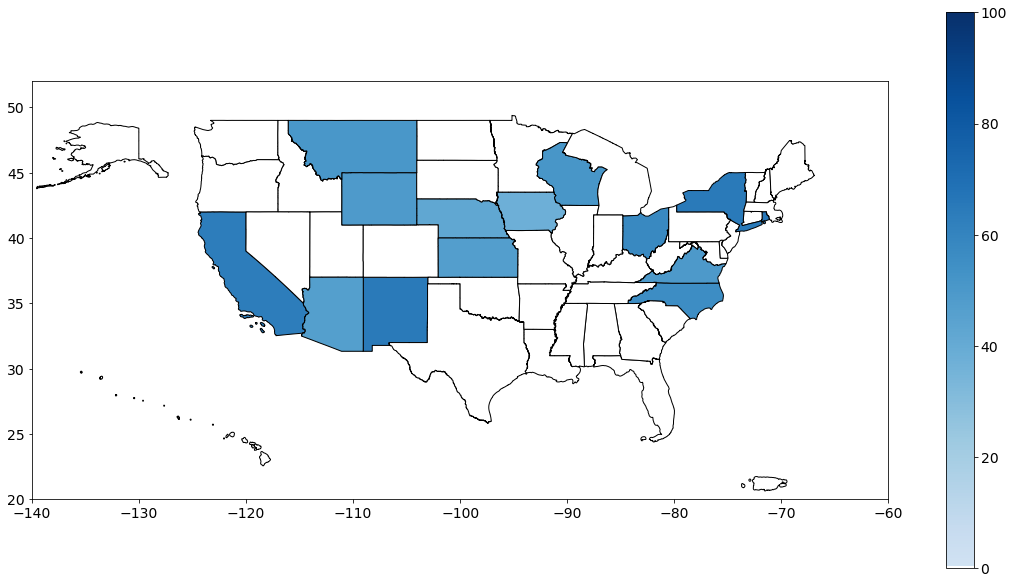

In [28]:
# Here I am coloring each of the states by their containment health government response score
val_col = np.zeros(len(state_map))
for l in locc:
    ind = state_map.loc[state_map.NAME == translator[l[:5]]].index[0]
    #val_col[ind] = cluster_select
    val_col[ind] = containment_health.loc[:,l[:5]][wpool.times[l][0]:wpool.times[l][1]].mean()

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (14,8))
state_map['val'] = val_col        
state_map.plot(column='val',legend=True, ax = ax, edgecolor = 'black', cmap = custom_cmap, norm = norm)
ax.set_xlim(-140, -60)
ax.set_ylim(20,52)

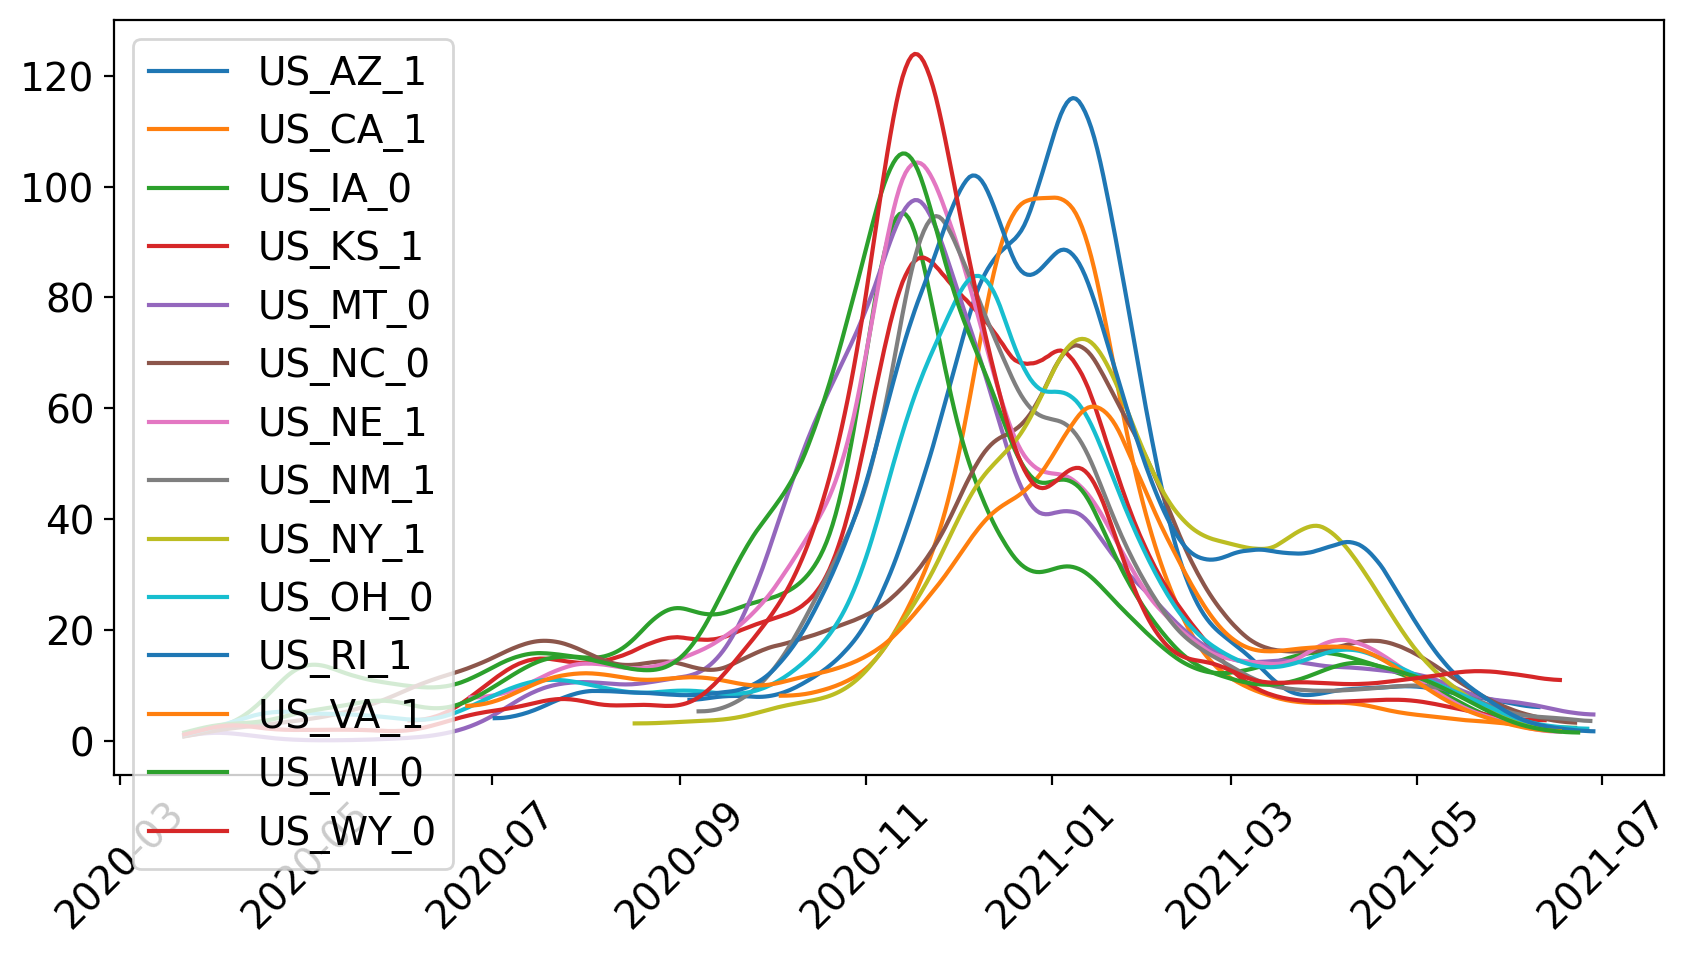

In [29]:
# Then we can also see the waves associated with each of the locations:
fig, ax = plt.subplots(figsize=(10,5), dpi = 200)

data_vis = data.loc[:,locs].copy(deep = True)

for i in range(len(indices)):
    wname = wpool.key_list[indices[i]]
    seg_times = wpool.times[wname]
    t1 = int(seg_times[0])
    t2 = int(seg_times[1])
    ax.plot(data.loc[:,wname[:5]][t1:t2], label = wname)
    
plt.xticks(rotation=45)
plt.legend()

## Clusters with Parameter Changes

In [30]:
# One question we thought was interesting is: how do clusters change as the parameter values change?
# Are clusters robust to parameter changes?

# Here we nalyze what happens for different choices of overlap and threshold parameters
# I'm loading in a bunch of pre-computed clusterings for various parameter settings 
uni_param_clusters = pd.read_csv('../batch/state/data/unimodal_param_clusterings.csv', index_col = 0)
sir_param_clusters = pd.read_csv('../batch/state/data/sir_param_clusterings.csv', index_col = 0)
wav_param_clusters = pd.read_csv('../batch/state/data/wav_param_clusterings.csv', index_col = 0)

In [31]:
# Choose a segmentation method to analyze:
wpool = wpool_uni
D = D_uni

In [32]:
# Then I'd like to determine if the cluster is robust to parameter choices
# To do so I'll again look for cliques of locations that show up 
# for different parameter choices. From the set of all cliques 
# I'll look for ones that contain or are contained by the current cluster
cluster_select = 51
indices = np.where(labels == cluster_select)[0]
locs = [wpool.key_list[i][:5] for i in indices]
locc = [wpool.key_list[i] for i in indices]

overlap_try = np.round(np.linspace(0.3,1,15),2)
threshold_try = np.round(np.linspace(0,0.4,21),2)
params = list(itertools.product(overlap_try, threshold_try))

# Looking for a slightly more specific range of parameters
max_overlap = 0.9
min_overlap = 0.6
max_threshold = 0.2
min_threshold = 0.02
idc = [i for i in range(len(params)) if params[i][0] <= max_overlap and params[i][0] >= min_overlap 
                                      and params[i][1] <= max_threshold and params[i][1] >= min_threshold]

uni_max = uni_param_clusters.iloc[idc, :]
column_pairs = list(combinations(uni_param_clusters.columns, 2))
cutoffs = np.linspace(0.1,1,10)[::-1]
cutoff_cliques = []

for cut in cutoffs:
    common_pairs = []
    for cp in column_pairs:
        if len(np.where((uni_max[cp[0]] == uni_max[cp[1]]))[0]) / len(uni_max) >= cut:
            common_pairs.append(cp)

    # find all cliques
    column_graph = nx.from_edgelist(common_pairs)
    cliques = list(nx.find_cliques(column_graph))
    foundc = None
    for cli in cliques:
        # If a found clique is a subclique or otherwise contains the current cluster,
        # record it
        if all(x in locc for x in cli):
            if foundc is None or len(foundc) < len(cli):
                foundc = cli
        if all(x in cli for x in locc):
            if foundc is None or len(foundc) < len(cli):
                foundc = cli
                
    cutoff_cliques.append(foundc)

(20.0, 52.0)

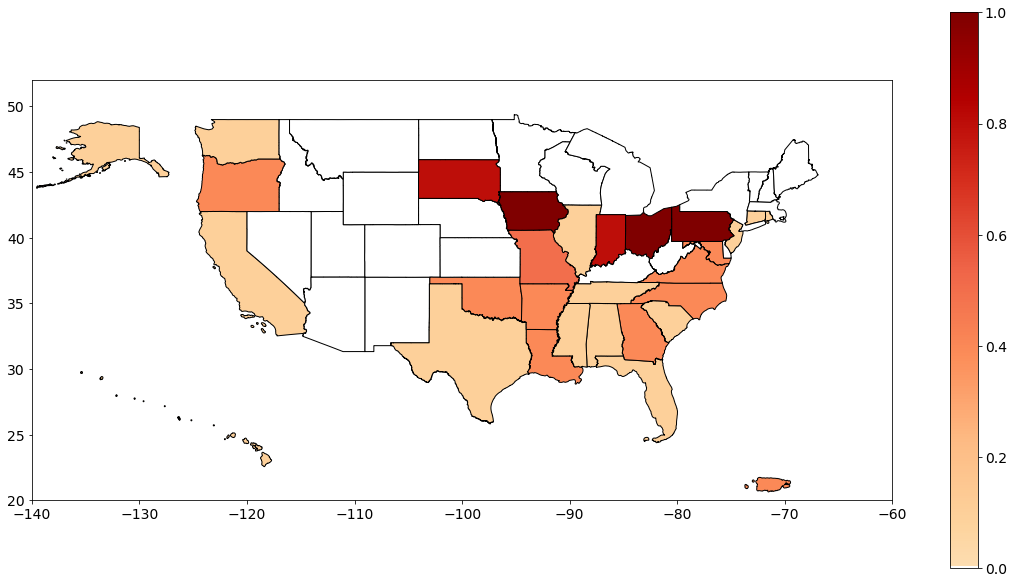

In [33]:
# Now I'll plot a map showing how often each location gets included in 
# the cluster. Darker colors indicate that the location was present in the 
# cluster across a higher percentage of the tested parameter values. 
sequential_cmap = plt.cm.OrRd
colors = [(1, 1, 1)] + [sequential_cmap(i) for i in range(50, 256)]  # White plus the blue scale
custom_cmap = ListedColormap(colors)
global_min, global_max = 0, 1
norm = Normalize(vmin=global_min, vmax=global_max)

val_col = np.zeros(len(state_map))
for p in range(len(cutoff_cliques)):
    if cutoff_cliques[p] is not None:
        p_locs = [i[:5] for i in cutoff_cliques[p]]
        p_locc = cutoff_cliques[p]
        for l in p_locc:
            ind = state_map.loc[state_map.NAME == translator[l[:5]]].index[0]
            if val_col[ind] == 0:
                val_col[ind] = cutoffs[p]

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (14,8))
state_map['val'] = val_col        
state_map.plot(column='val',legend=True, ax = ax, edgecolor = 'black', cmap = custom_cmap, norm = norm)
#ax.set_xlim(-90, -60)
#x.set_ylim(35,52)
ax.set_xlim(-140, -60)
ax.set_ylim(20,52)

(array([18932., 18962., 18993., 19024., 19052., 19083., 19113.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

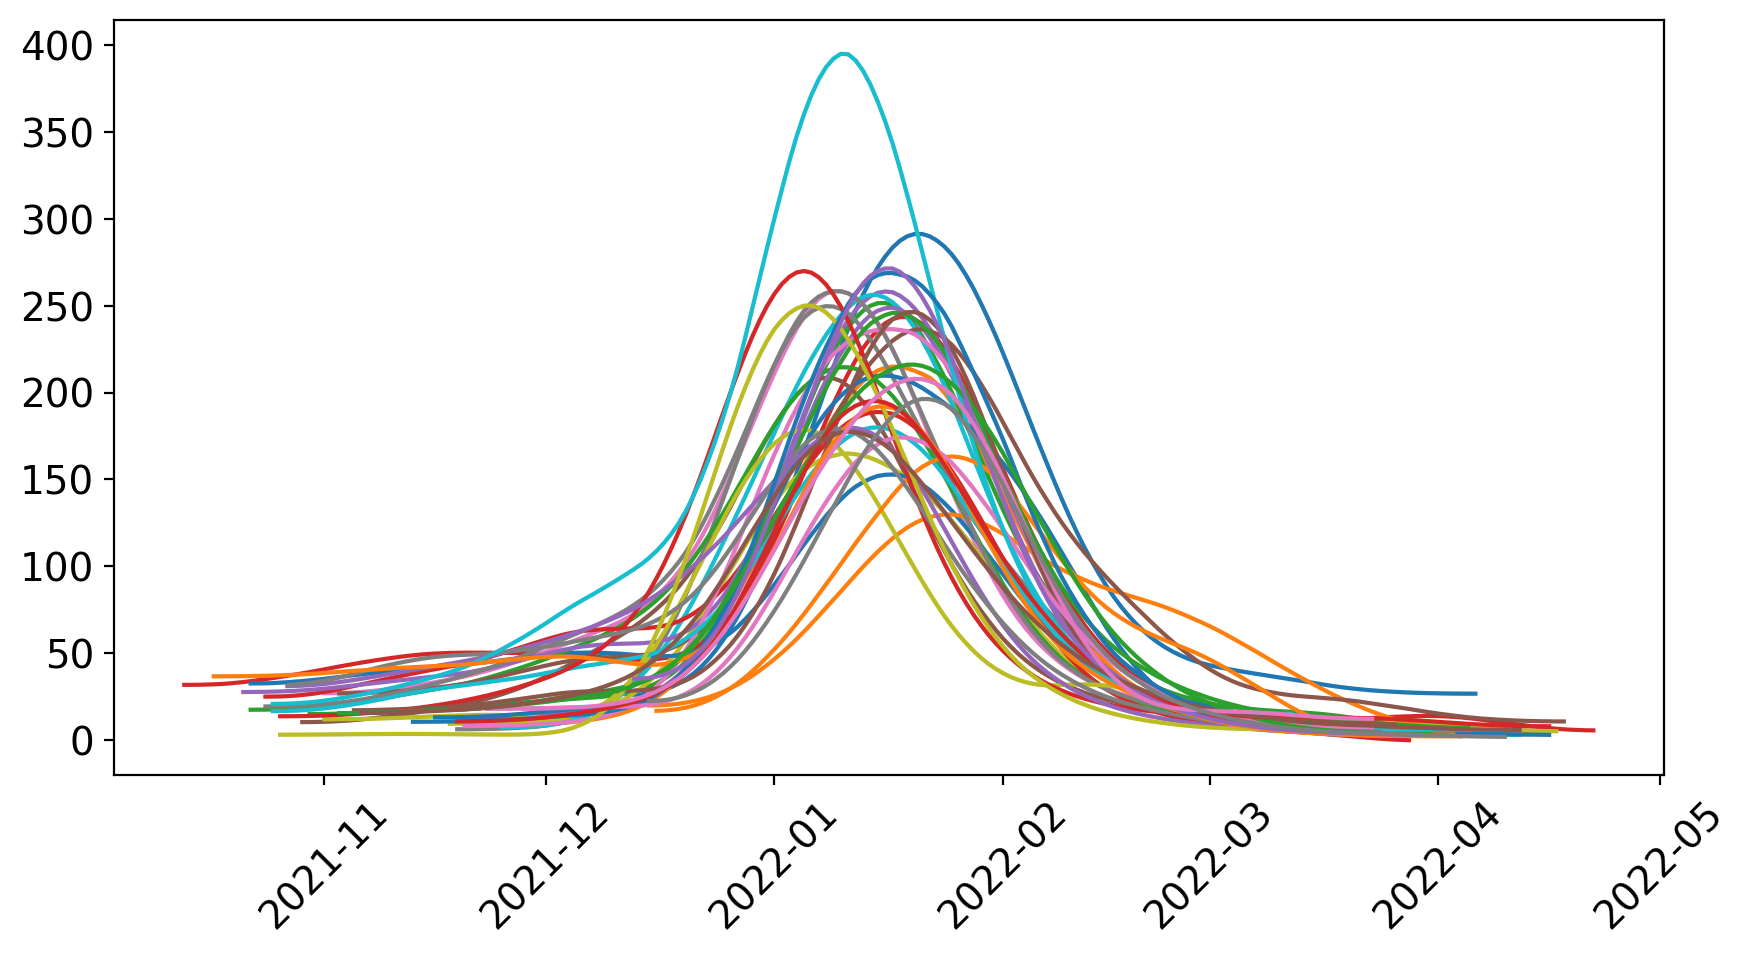

In [34]:
# Plot the waves for all of these locations
fig, ax = plt.subplots(figsize=(10,5), dpi = 200)

unique_elements = set(element for sublist in cutoff_cliques if sublist is not None for element in sublist)
unique_elements_list = list(unique_elements)
clique_locs = [i[:5] for i in unique_elements_list]


for i in range(len(unique_elements)):
    wname = unique_elements_list[i]
    seg_times = wpool.times[wname]
    t1 = int(seg_times[0])
    t2 = int(seg_times[1])
    ax.plot(data.loc[:,wname[:5]][t1:t2], color = 'k', alpha = 0.1)
    

for i in range(len(indices)):
    wname = wpool.key_list[indices[i]]
    seg_times = wpool.times[wname]
    t1 = int(seg_times[0])
    t2 = int(seg_times[1])
    ax.plot(data.loc[:,wname[:5]][t1:t2], label = wname)
    
plt.xticks(rotation=45)
#plt.legend()

### Clusters by Time

In [35]:
# We're also interested in being able to see multiple clusters at once.
# This gives a sense of the overall patterns, and allows us to see how they change over time.

# Given a single time stamp, this function will
# find all wave segments which pass over that time
def get_segments(time, time_frame):
    time_segments = []
    for segment in range(len(wpool.key_list)):
        wname = wpool.key_list[segment]
        wtimes = wpool.times[wname]
        if time >= wtimes[0] and time < wtimes[1]:
            if wtimes[0] >= time_frame[0] and wtimes[1] <= time_frame[1]:
                time_segments.append(segment)
    return time_segments

# Given a list of segments that cross over some time,
# Find all clusters which are fully represented by that list,
# I.e. only record a cluster as present if all of its segments are in the input list
def segment_clusters(segments):
    time_segment_clusters = []
    for c in range(len(cliquer.C)):
        cluster = set(cliquer.C[c])
        covered = set()
        for seg in segments:
            if seg in cluster:
                covered = covered.union({seg})
                
        if cluster == covered:
            time_segment_clusters.append(c)
                    
    return time_segment_clusters

In [36]:
# Now the question is, what times should we choose?
# here's the list of times that I considered -- which are more 
# or less evenly spaced across the pandemic, with some priority 
# given to times where alot of infection activity is happening.

# For each I also define a time frame (t1,t2)
# just so that were looking at a more localized window
# 0: (0,250)
# 250: (0, 500)
# 550: (400,700)
# 650: (400, 800)
# 800: (700, 900)

time = 800
time_frame = (700,900)
time_segments = get_segments(time, time_frame)
time_segment_clusters = segment_clusters(time_segments)

locs = [wpool.key_list[i][:5] for i in time_segments]
loccs = [wpool.key_list[i] for i in time_segments]

sequential_cmap = plt.cm.tab20
unique_clusters = np.sort(list(set(time_segment_clusters)))
colors = [(1, 1, 1)] + [sequential_cmap(i) for i in range(20)]
custom_cmap = ListedColormap(colors)

color_indices = np.round(np.linspace(1, len(colors) - 1, len(unique_clusters))).astype(int)
color_dict = {unique_clusters[i]:colors[color_indices[i]] for i in range(len(unique_clusters))}
color_dict[-1] = colors[0]

/share/pkg.7/python3/3.9.9/install/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


([], [])

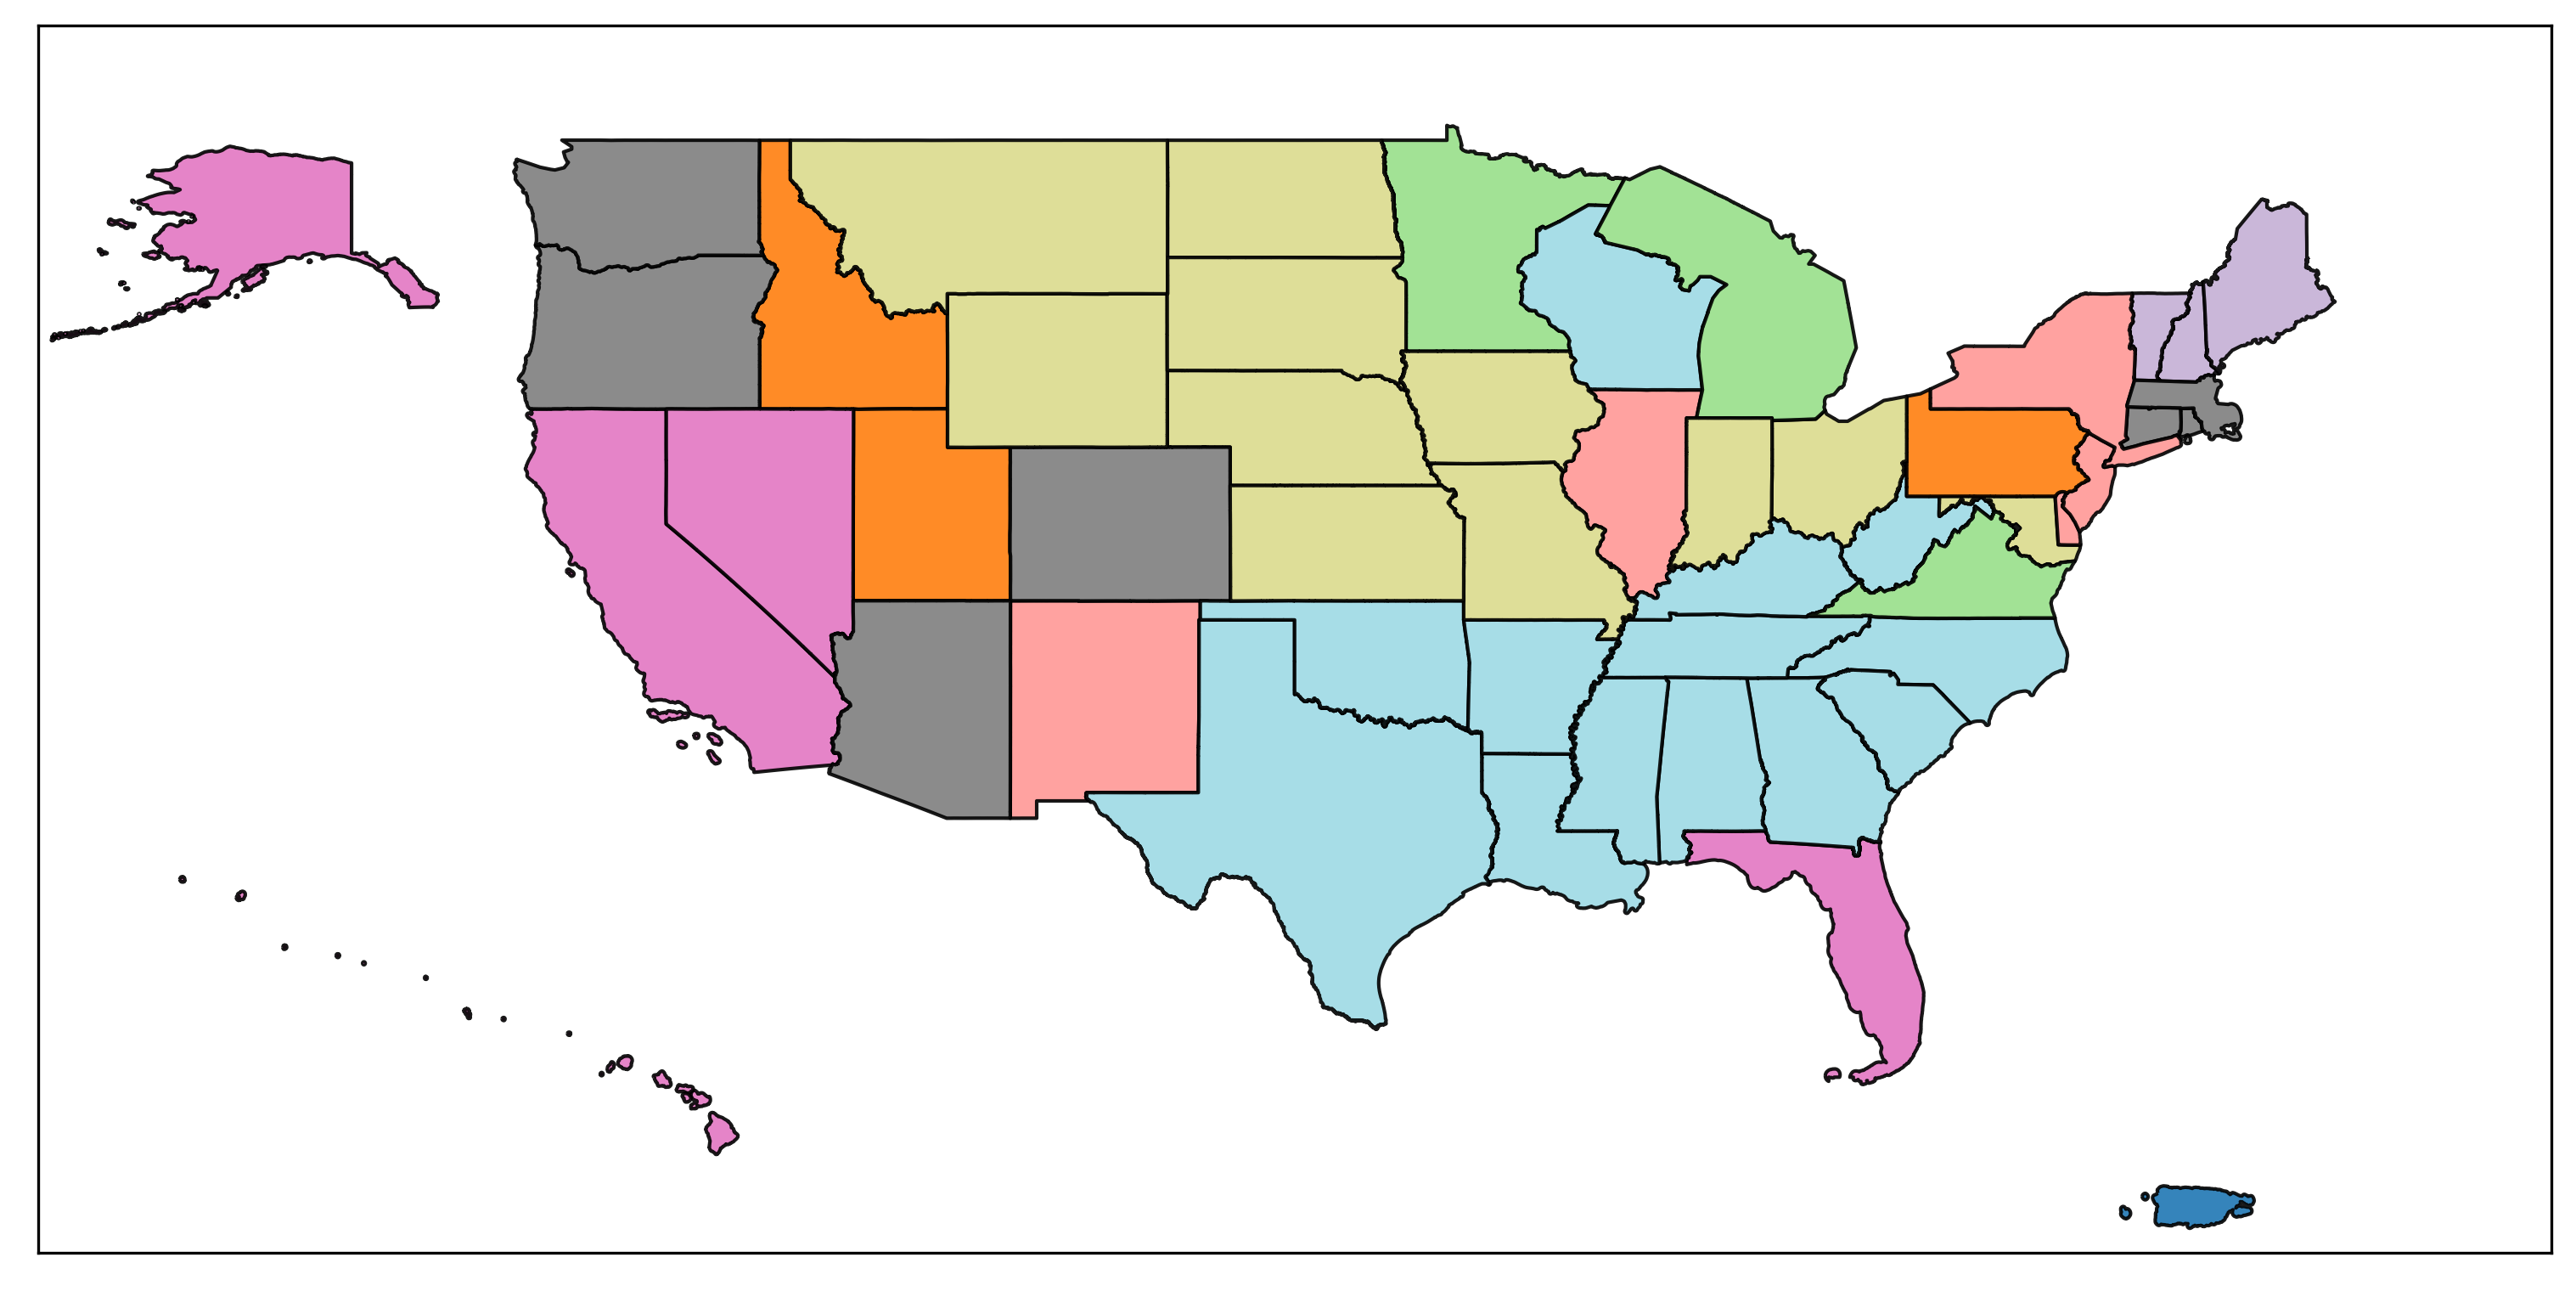

In [37]:
val_col = np.zeros(len(state_map)) - 1
for c in unique_clusters:
    #if len(cliquer.C[c]) > 1:
    for i in cliquer.C[c]:
        location = wpool.key_list[i][:5]
        ind = state_map.loc[state_map.NAME == translator[location]].index[0]
        val_col[ind] = c


fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (10,10), dpi = 300)
state_map['val'] = val_col
state_map['color'] = state_map['val'].map(color_dict)
state_map.plot(color=state_map['color'].to_list() ,legend=False, ax = ax, edgecolor = 'black', alpha = 0.9)
ax.set_xlim(-140, -60)
ax.set_ylim(20,52)
plt.xticks([])
plt.yticks([]) 

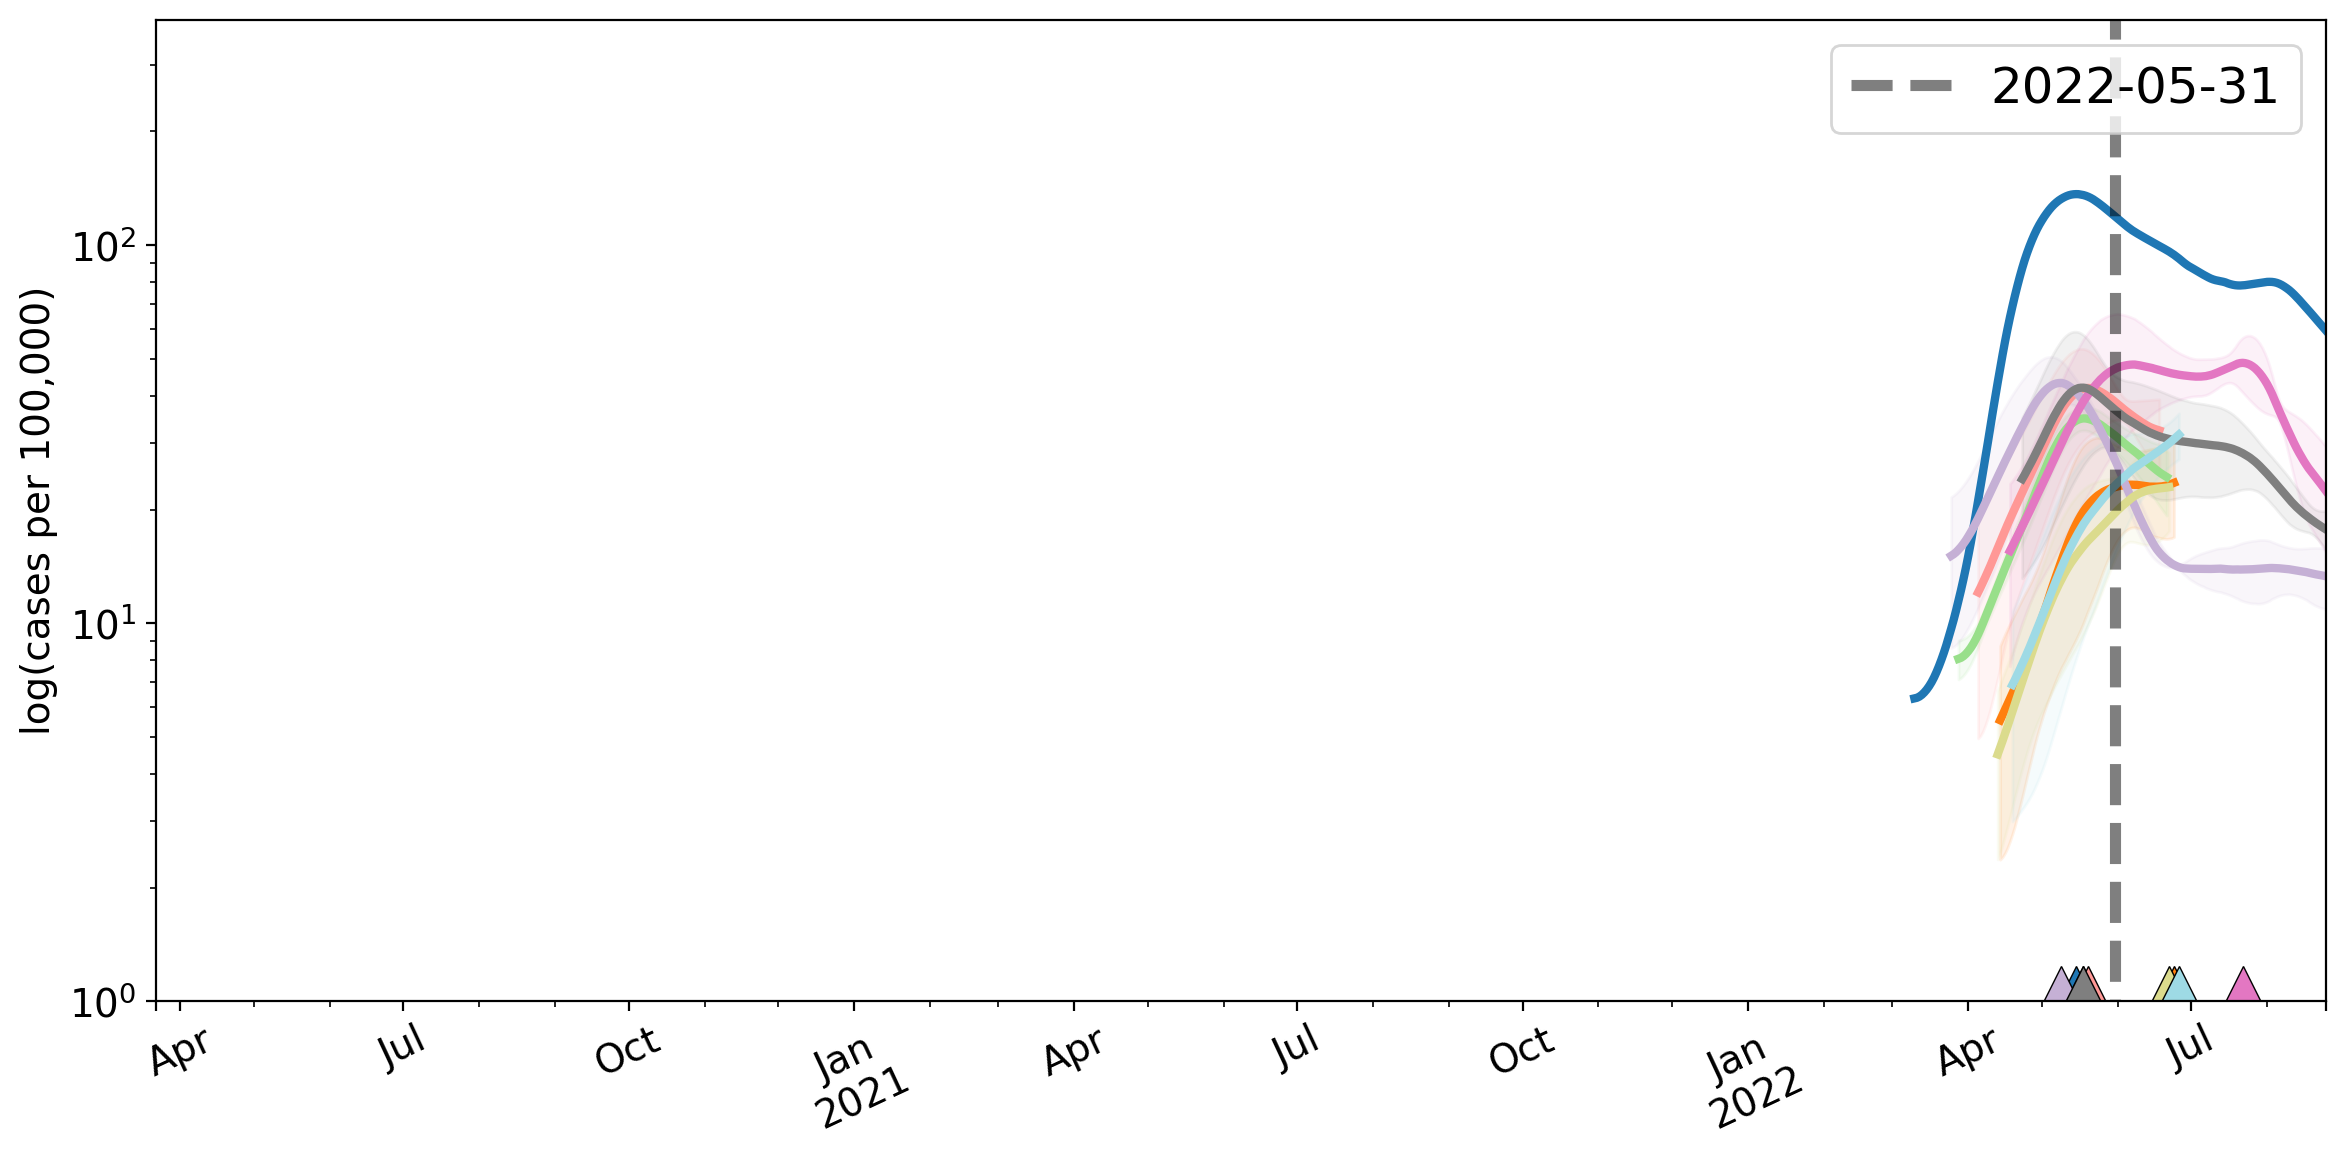

In [38]:
# For each of the clusters on the map, I also 
# display the average wave associated with it
fig,ax = plt.subplots(figsize = (14,6.5), dpi = 200)
plt.rcParams.update({'font.size': 18})
data_max = 0

def maxer(inp):
    return max(inp,1)

for u in unique_clusters:
    wvs = cluster_waves[u]
    cluster_color = color_dict[u]
    x = wvs.index
    mean = wvs.mean(axis = 1)
    std = wvs.std(axis = 1)
    
    mean.plot(c = cluster_color, linewidth = 3, label='_no_legend_')
    ax.fill_between(x, mean - std, mean + std, color=cluster_color, alpha=0.1)
    
    max_idx = np.argmax(mean)
    ax.plot(x[max_idx], 1, marker='^', markersize=25, c=cluster_color, markeredgewidth=0.5, markeredgecolor='black')

    umax = mean.max() + std.max()
    if umax > data_max:
        data_max = umax

        
data_max = data.max().max()
date_line = ax.vlines(x = data.index[time], ymin = 0, ymax = data_max, linestyle = '--', color = 'k', linewidth = 4, label = str(data.index[time])[:10], alpha = 0.5)
ax.set_xlabel('')
ax.set_ylabel('log(cases per 100,000)')
ax.set_yscale('log', base=10)
ax.set_ylim(1, data_max)
plt.xticks(rotation=25) 
plt.legend()

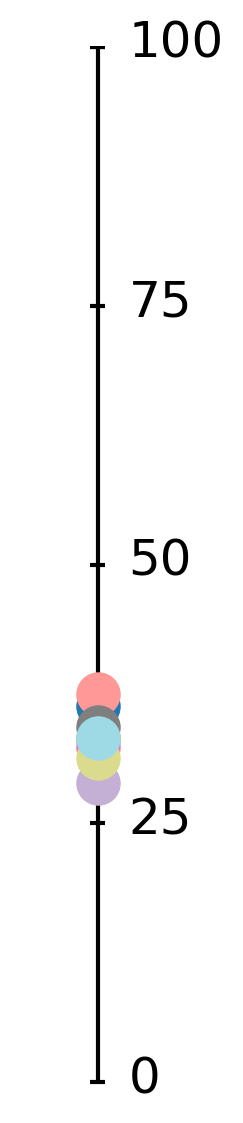

In [39]:
# set up the figure
fig = plt.figure(figsize = (1,7), dpi = 200)
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 18})

# draw lines
ymin = 0
ymax = 100
ax.set_ylim(ymin-2,ymax+0.1)

x = 5
height = 1
ax.set_xlim(0,10)

plt.vlines(x, ymin, ymax, color = 'k')
plt.hlines(ymin, x - height/2, x + height/2, color = 'k')
plt.hlines(ymax, x - height/2, x + height/2, color = 'k')
plt.hlines(ymax, x - height/2, x + height/2, color = 'k')
plt.hlines(ymax//4, x - height / 2., x + height / 2., color = 'k')
plt.hlines(ymax//2, x - height/2, x + height/2, color = 'k')
plt.hlines(3*ymax//4, x - height / 2, x + height / 2, color = 'k')

# draw a point on the line
px = 4
for u in unique_clusters:
    health_val = cluster_data.loc[cluster_data.cluster == u].containment_health.values[0]
    cluster_color = color_dict[u]
    plt.plot(x, health_val, marker = 'o', ms = 15, color = cluster_color, linewidth = 10)


# add numbers
plt.text(x+2, ymin - 1, '0')#, horizontalalignment='right')
plt.text(x+2, ymax - 1, '100')#, horizontalalignment='left')
plt.text(x+2, ymax//4 - 1, '25')#, horizontalalignment='left')
plt.text(x+2, ymax//2 - 1, '50')#, horizontalalignment='left')
plt.text(x+2, 3*ymax//4 - 1, '75')#, horizontalalignment='left')

plt.axis('off')
plt.show()

In [110]:
peaks = []
peak_times = []
response_vals = []
for u in unique_clusters:
    u_peaks = []
    u_times = []
    u_response = []
    for c in cliquer.C[u]:
        cname = wpool.key_list[c]
        ctimes = wpool.times[cname]
        data_vec = data.loc[:,cname[:cname.rfind('_')]][ctimes[0]:ctimes[1]]
        response_vec = containment_health.loc[:,cname[:cname.rfind('_')]][ctimes[0]:ctimes[1]]
        u_peaks.append(data_vec.max())
        u_times.append(data_vec.index[data_vec.argmax()])
        u_response.append(response_vec.mean())
        
    peaks.append(u_peaks)
    peak_times.append(u_times)
    response_vals.append(u_response)

Text(0, 0.5, 'Peak Infection')

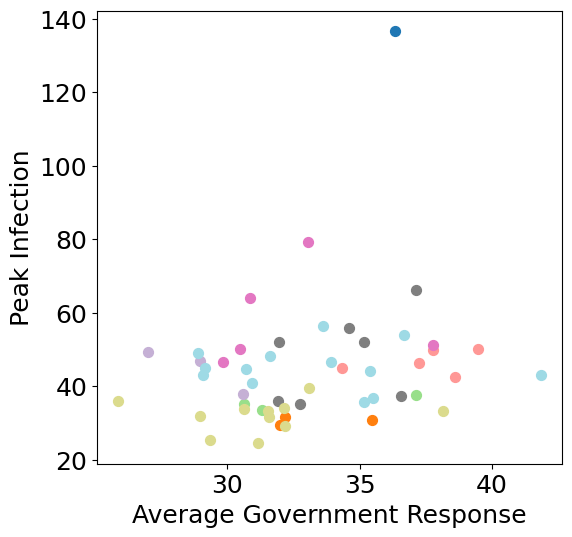

In [111]:
fig,ax = plt.subplots(figsize = (6,6), dpi = 100)

for i in range(len(unique_clusters)):
    cluster_color = color_dict[unique_clusters[i]]
    ax.scatter(response_vals[i], peaks[i], marker = 'o', s = 50, color = cluster_color)
    
ax.set_xlabel('Average Government Response')
ax.set_ylabel('Peak Infection')

Text(0, 0.5, 'Peak Infection Time')

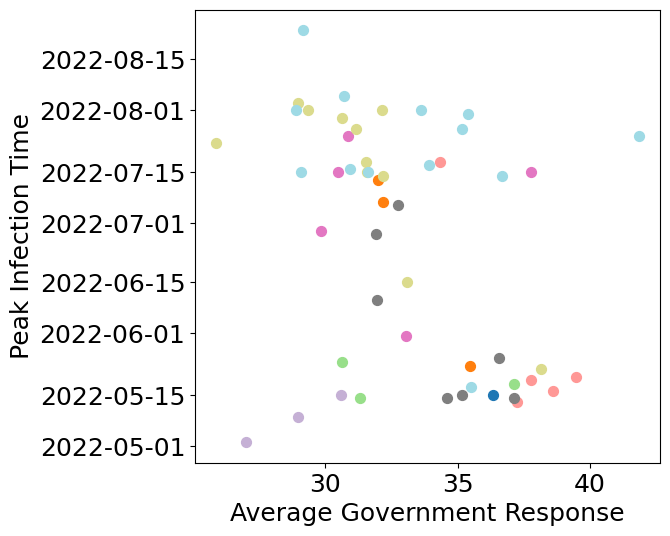

In [112]:
fig,ax = plt.subplots(figsize = (6,6), dpi = 100)

for i in range(len(unique_clusters)):
    cluster_color = color_dict[unique_clusters[i]]
    ax.scatter(response_vals[i], peak_times[i], marker = 'o', s = 50, color = cluster_color)
    
ax.set_xlabel('Average Government Response')
ax.set_ylabel('Peak Infection Time')

## Comparison to random clusterings

In [40]:
# One of our goals is to analyze computed statistics from our clusterings, 
# and measure them against random baselines. We computed this earlier for a 
# single cluster -- results were in cluster_data 
# Here I read some precomputed results from each of our segmentation methods:
uni_analysis = pd.read_csv('../batch/state/data/unimodal_analysis.csv', index_col = 0)
# Look only at non-singleton clusters
uni_filter = uni_analysis.loc[uni_analysis.cluster_size >= 2]

sir_analysis = pd.read_csv('../batch/state/data/sir_analysis.csv', index_col = 0)
sir_filter = sir_analysis.loc[sir_analysis.cluster_size >= 2]

wav_analysis = pd.read_csv('../batch/state/data/wav_analysis.csv', index_col = 0)
wav_filter = wav_analysis.loc[wav_analysis.cluster_size >= 2]

In [41]:
# Then for comparison I'm also going to read in some computed statistics 
# for a few different randomized baselines

#1) random clusterings after using each of the segmentation methdods
uni_rc_analysis = pd.read_csv('../batch/state/data/unimodal_rc_analysis.csv', index_col = 0)
uni_rc_filter = uni_rc_analysis.loc[uni_rc_analysis.cluster_size >= 2]
#uni_rc_filter = uni_rc_filter.loc[uni_rc_filter.clustering <= 1000]

sir_rc_analysis = pd.read_csv('../batch/state/data/sir_rc_analysis.csv', index_col = 0)
sir_rc_filter = sir_rc_analysis.loc[sir_rc_analysis.cluster_size >= 2]
#sir_rc_filter = sir_rc_filter.loc[sir_rc_filter.clustering <= 1000]

wav_rc_analysis = pd.read_csv('../batch/state/data/wav_rc_analysis.csv', index_col = 0)
wav_rc_filter = wav_rc_analysis.loc[wav_rc_analysis.cluster_size >= 2]
#wav_rc_filter = wav_rc_filter.loc[wav_rc_filter.clustering <= 1000]

#2) random segmentation followed by clique clustering
rs_analysis = pd.read_csv('../batch/state/data/random_segment_clusters.csv', index_col = 0)
rs_filter = rs_analysis.loc[rs_analysis.cluster_size >= 2]

#3) random segmentation followed by random clustering
rc_rs_analysis = pd.read_csv('../batch/state/data/random_segment_random_clusters.csv', index_col = 0)
rc_rs_filter = rc_rs_analysis.loc[rc_rs_analysis.cluster_size >= 2]

In [42]:
# Select the measure for comparison
compare = 'silhouette'

# use weight = True for any silhouette scores (compare = silhouette) to get the accurate result...otherwise use weight = False
# (More on this in the cell below!)
weight = True

In [43]:
# The following snippets all take the pre-computed data and compute average values 
# for the comparison statistic within each clustering. That is, each cluster in a clustering 
# has a value for the comparison variable, and we average over all clusters to compute an
# average measure for the clustering. 

# sizes of all the different clusterings (number of clusters in the clustering)
rc_clusterings = uni_rc_filter.clustering.value_counts()

# Adjusted sizes to remove clusters with zero valued silhouette scores
# We do this because there are many clusters which have 0 valued silhouette scores because 
# the segments in the cluster cannot possibly join any other cluster -- because of clique constraints.
# What we really want to analyze is, for clusters where wave segments CAN possibly switch their cluster membership (i.e. have 
# non-zero silhouette score), does our method distinguish from a random baseline?
# NOTE: however, that you can also see what happens without this adjustment by setting weight = False when using compare = 'silhouette'
#      it doesnt seem to change very much!
sizes = np.array([uni_rc_filter.loc[uni_rc_filter['clustering'] == i].cluster_size[uni_rc_filter['silhouette'] != 0].sum() for i in rc_clusterings.index])

# Unimodal Random Clusterings
uni_rc_means = np.zeros(len(rc_clusterings))
rc_dict = {rc_clusterings.index[i]:i for i in range(len(rc_clusterings))}
for row in uni_rc_filter.index:
    idx = rc_dict[uni_rc_filter.loc[row, 'clustering']]
    if weight:
        uni_rc_means[idx] += uni_rc_filter.loc[row, compare]*uni_rc_filter.loc[row, 'cluster_size']
    else:
        uni_rc_means[idx] += uni_rc_filter.loc[row, compare]

# Adjusting average with the size of clusterings
if weight:
    uni_rc_means = uni_rc_means / sizes
else:
    uni_rc_means = uni_rc_means / rc_clusterings.to_numpy()

In [44]:
# SIR random clusterings
rc_clusterings = sir_rc_filter.clustering.value_counts()
sizes = np.array([sir_rc_filter.loc[sir_rc_filter['clustering'] == i].cluster_size[sir_rc_filter['silhouette'] != 0].sum() for i in rc_clusterings.index])

sir_rc_means = np.zeros(len(rc_clusterings))
rc_dict = {rc_clusterings.index[i]:i for i in range(len(rc_clusterings))}
for row in sir_rc_filter.index:
    idx = rc_dict[sir_rc_filter.loc[row, 'clustering']]
    if weight:
        sir_rc_means[idx] += sir_rc_filter.loc[row, compare]*sir_rc_filter.loc[row, 'cluster_size']
    else:
        sir_rc_means[idx] += sir_rc_filter.loc[row, compare]
    
    
if weight:
    sir_rc_means = sir_rc_means / sizes
else:
    sir_rc_means = sir_rc_means / rc_clusterings.to_numpy()

In [45]:
# Wavefinder random clusterings
rc_clusterings = wav_rc_filter.clustering.value_counts()
sizes = np.array([wav_rc_filter.loc[wav_rc_filter['clustering'] == i].cluster_size[wav_rc_filter['silhouette'] != 0].sum() for i in rc_clusterings.index])

wav_rc_means = np.zeros(len(rc_clusterings))
rc_dict = {rc_clusterings.index[i]:i for i in range(len(rc_clusterings))}
for row in wav_rc_filter.index:
    idx = rc_dict[wav_rc_filter.loc[row, 'clustering']]
    if weight:
        wav_rc_means[idx] += wav_rc_filter.loc[row, compare]*wav_rc_filter.loc[row, 'cluster_size']
    else:
        wav_rc_means[idx] += wav_rc_filter.loc[row, compare]
    
if weight:
    wav_rc_means = wav_rc_means / sizes
else:
    wav_rc_means = wav_rc_means / rc_clusterings.to_numpy()

In [46]:
# Random Segmentation + Non-random clustering
rs_clusterings = rs_filter['sample'].value_counts()
sizes = np.array([rs_filter.loc[rs_filter['sample'] == i].cluster_size[rs_filter['silhouette'] != 0].sum() for i in rs_clusterings.index])

rs_means = np.zeros(len(rs_clusterings))
rs_dict = {rs_clusterings.index[i]:i for i in range(len(rs_clusterings))}
for row in rs_filter.index:
    idx = rs_dict[rs_filter.loc[row, 'sample']]
    if weight:
        rs_means[idx] += rs_filter.loc[row, compare]*rs_filter.loc[row, 'cluster_size']
    else:
        rs_means[idx] += rs_filter.loc[row, compare]
    
if weight:
    rs_means = rs_means / sizes
else:
    rs_means = rs_means / rs_clusterings.to_numpy()

In [47]:
# Random segmentation + random clustering
rc_rs_clusterings = rc_rs_filter['sample'].value_counts()
sizes = np.array([rc_rs_filter.loc[rc_rs_filter['sample'] == i].cluster_size[rc_rs_filter['silhouette'] != 0].sum() for i in rc_rs_clusterings.index])

rc_rs_means = np.zeros(len(rc_rs_clusterings))
rc_rs_dict = {rc_rs_clusterings.index[i]:i for i in range(len(rc_rs_clusterings))}
for row in rc_rs_filter.index:
    idx = rc_rs_dict[rc_rs_filter.loc[row, 'sample']]
    if weight:
        rc_rs_means[idx] += rc_rs_filter.loc[row, compare]*rc_rs_filter.loc[row, 'cluster_size']
    else:
        rc_rs_means[idx] += rc_rs_filter.loc[row, compare]
 
if weight:
    rc_rs_means = rc_rs_means / sizes
else:
    rc_rs_means = rc_rs_means / rc_rs_clusterings.to_numpy()

(array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

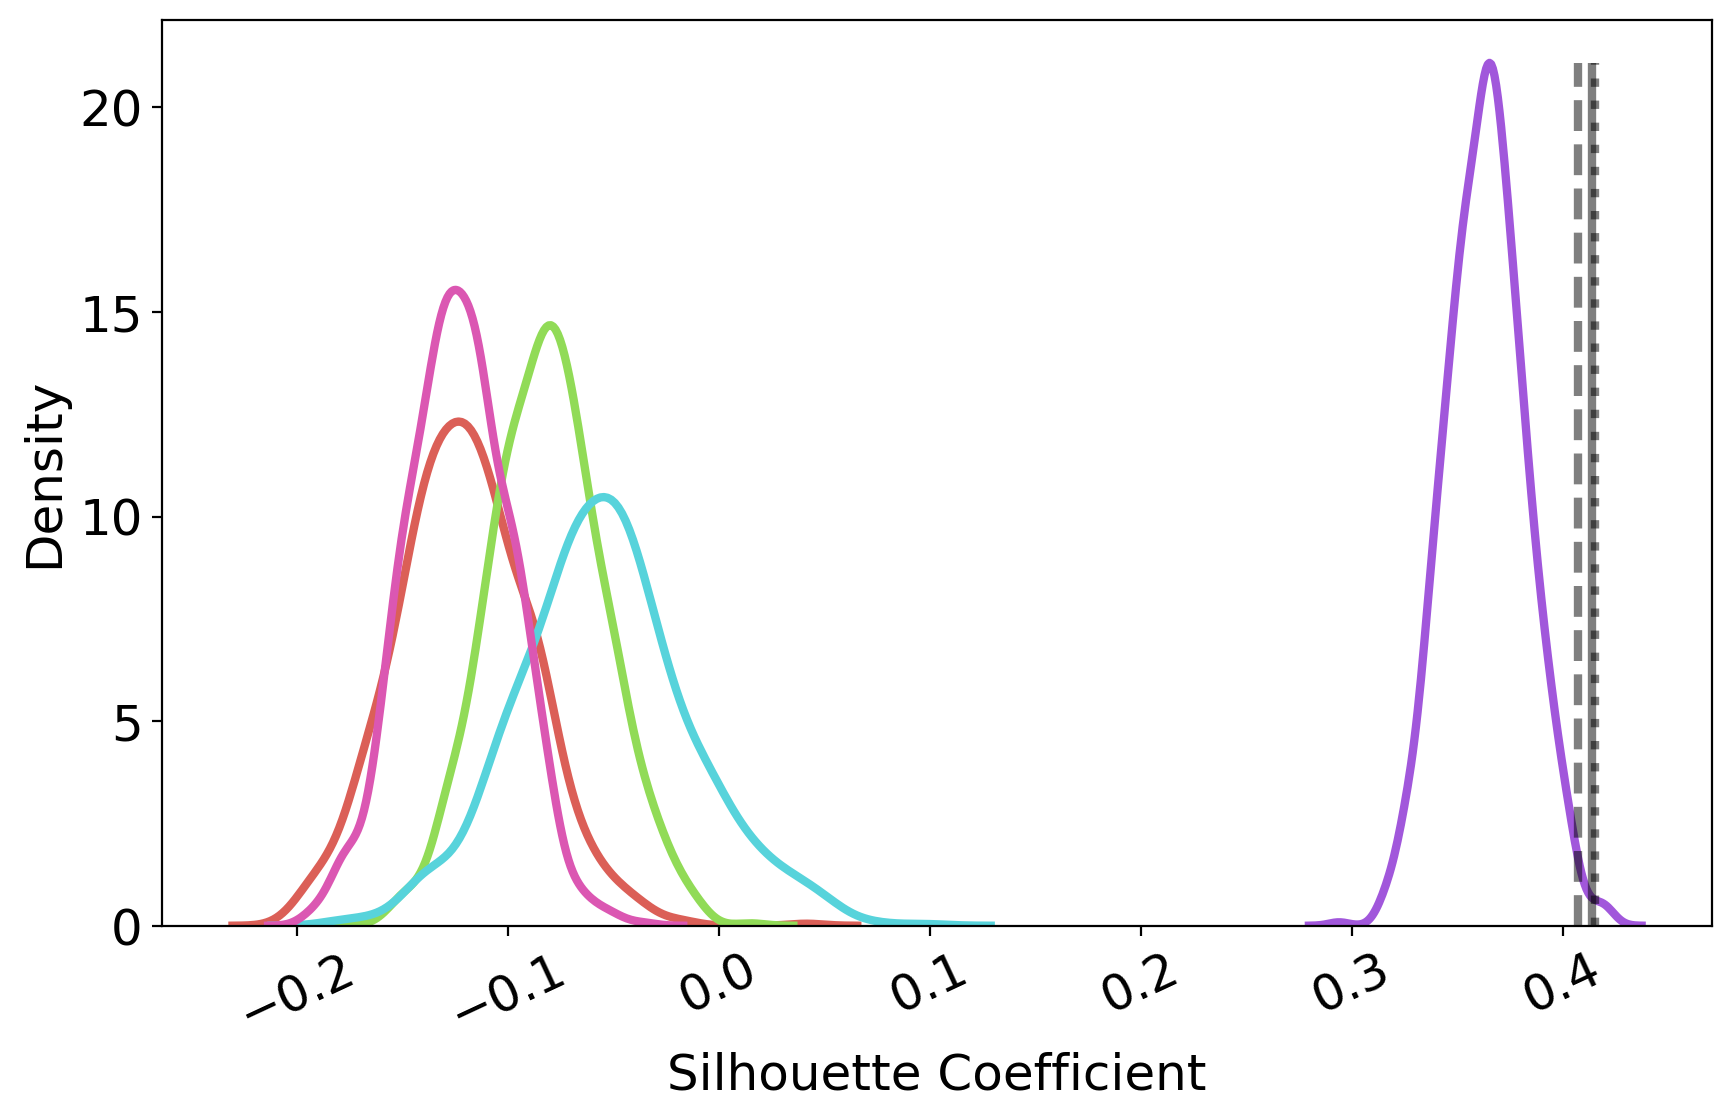

In [48]:
# visualize results
fig,ax = plt.subplots(figsize = (10,6), dpi = 200)
plt.rcParams.update({'font.size': 22})
pal = sns.color_palette("hls", 8)
s1 = sns.kdeplot(uni_rc_means, ax = ax, color = pal[0], label = 'Unimodal random', linewidth = 3)
s2 = sns.kdeplot(sir_rc_means, ax = ax, color = pal[2], label = 'SIR random', linewidth = 3)
s3 = sns.kdeplot(wav_rc_means, ax = ax, color = pal[4], label = 'WAV random', linewidth = 3)
s4 = sns.kdeplot(rs_means, ax = ax, color = pal[6], label = 'random segments', linewidth = 3)
s5 = sns.kdeplot(rc_rs_means, ax = ax, color = pal[7], label = 'random both', linewidth = 3)

max_height = 0
for l in range(len(ax.lines)):
    _,y = ax.lines[l].get_data()
    if np.max(y) > max_height:
        max_height = np.max(y)
        
if weight:
    uni_avg = np.sum((uni_filter.loc[:,compare] * uni_filter.loc[:, 'cluster_size'])) / uni_filter.cluster_size[uni_filter['silhouette'] != 0].sum()
    sir_avg = np.sum((sir_filter.loc[:,compare] * sir_filter.loc[:, 'cluster_size'])) / sir_filter.cluster_size[sir_filter['silhouette'] != 0].sum()
    wav_avg = np.sum((wav_filter.loc[:,compare] * wav_filter.loc[:, 'cluster_size'])) / wav_filter.cluster_size[wav_filter['silhouette'] != 0].sum()
else:
    uni_avg = uni_filter.loc[:,compare].mean()
    sir_avg = sir_filter.loc[:,compare].mean()
    wav_avg = wav_filter.loc[:,compare].mean()
    
ax.vlines(x = uni_avg, ymin = 0, ymax = max_height, linestyle = 'solid', color = 'k', 
          linewidth = 3, label = 'Unimodal', alpha = 0.5)

ax.vlines(x = sir_avg, ymin = 0, ymax = max_height, linestyle = '--', color = 'k', 
          linewidth = 3, label = 'SIR', alpha = 0.5)

ax.vlines(x = wav_avg, ymin = 0, ymax = max_height, linestyle = 'dotted', color = 'k', 
          linewidth = 3, label = 'WAV', alpha = 0.5)

ax.set_xlabel('Silhouette Coefficient')

plt.xticks(rotation=25) 
#plt.legend(fontsize = 18, loc = 'upper left')

## Change over time

In [55]:
# Now we'd like to measure how those statistics 
# changed over time
size_average = []
silhouette_average = []
geographic_average = []
health_average = []
size_std = []
silhouette_std = []
geographic_std = []
health_std = []
times = list(range(data.shape[0]))

# for every time stamp
for t in times:
    time = times[t]
    
    # find all clusters fully present at that time
    segs = get_segments(time, (0,1000))
    seg_clusters = segment_clusters(segs)

    # And measure the average across all those clusters
    size = []
    sil = []
    geo = []
    health = []
    for c in seg_clusters:
        cdata = cluster_data.loc[cluster_data.cluster == c]
        size.append(cdata.cluster_size.values[0])
        sil.append(cdata.silhouette.values[0])
        geo.append(cdata.geo_pairwise.values[0])
        health.append(cdata.health_pairwise.values[0])

    size_average.append(np.mean(size))
    silhouette_average.append(np.mean(sil))
    geographic_average.append(np.mean(geo))
    health_average.append(np.mean(health))
    
    size_std.append(np.std(size))
    silhouette_std.append(np.std(sil))
    geographic_std.append(np.std(geo))
    health_std.append(np.std(health))
    
averages = pd.DataFrame(np.array([size_average,silhouette_average, geographic_average, health_average])).T
averages.columns = ['size', 'silhouette', 'geographic', 'health']
averages.index = data.index

stds = pd.DataFrame(np.array([size_std,silhouette_std, geographic_std, health_std])).T
stds.columns = ['size', 'silhouette', 'geographic', 'health']
stds.index = data.index

In [ ]:
wvs = cluster_waves[u]
    cluster_color = color_dict[u]
    x = wvs.index
    mean = wvs.mean(axis = 1)
    std = wvs.std(axis = 1)
    
    mean.plot(c = cluster_color, linewidth = 3, label='_no_legend_')
    ax.fill_between(x, mean - std, mean + std, color=cluster_color, alpha=0.1)
    
    max_idx = np.argmax(mean)
    ax.plot(x[max_idx], 1, marker='^', markersize=25, c=cluster_color, markeredgewidth=0.5, markeredgecolor='black')

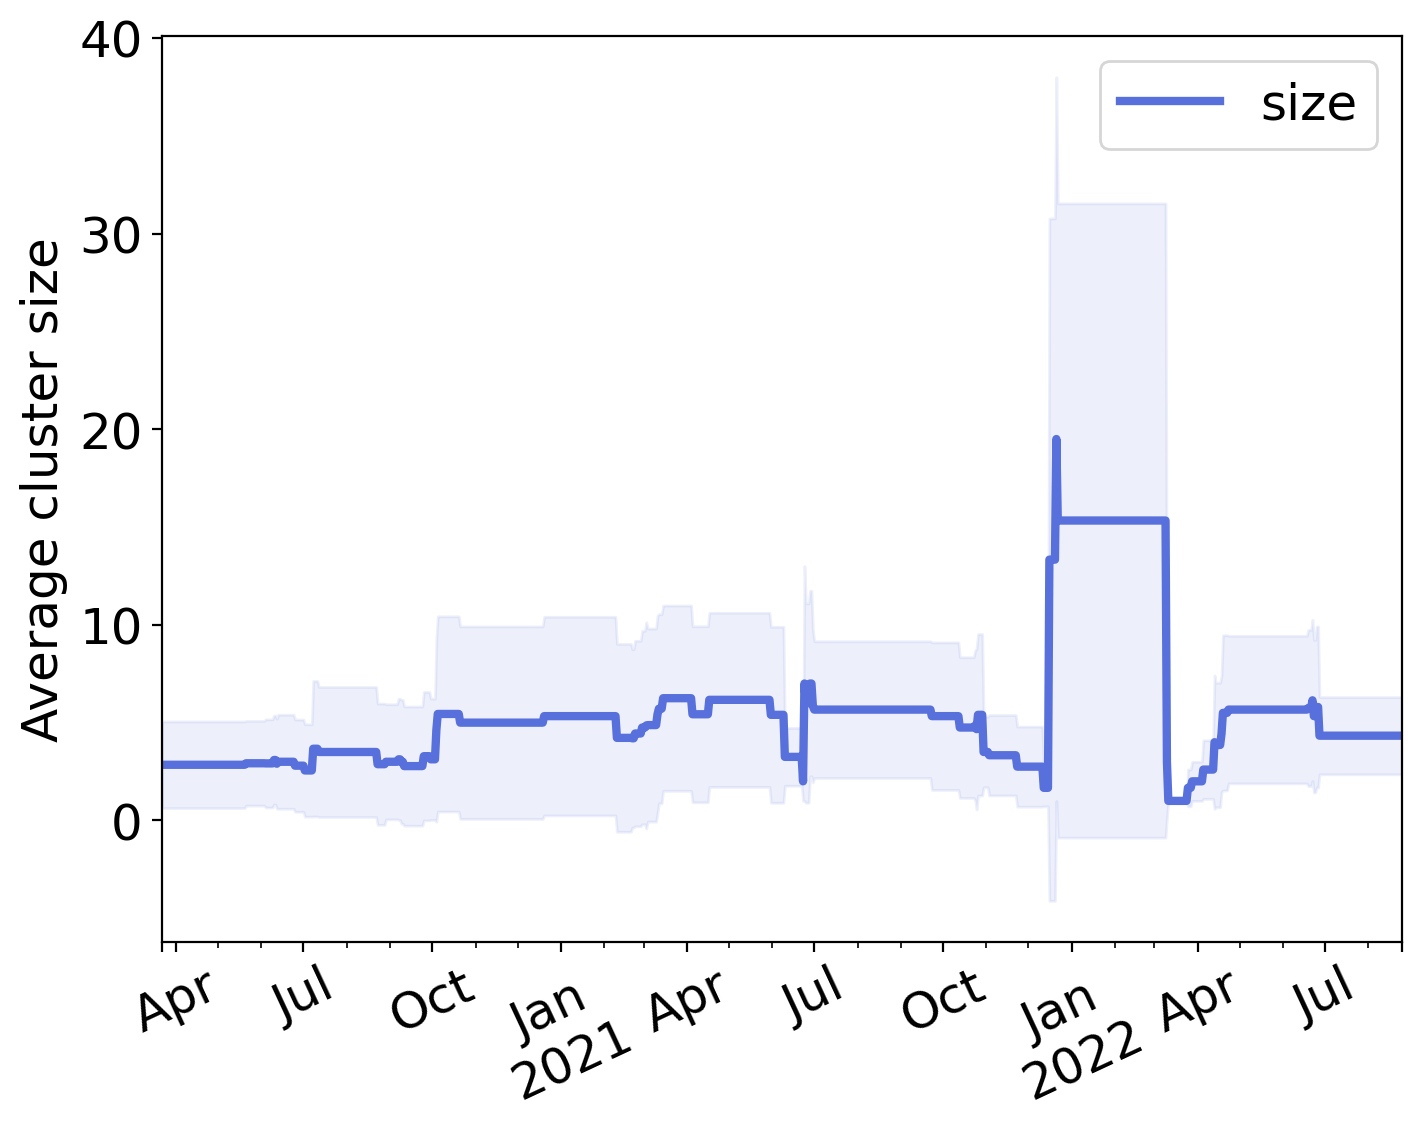

In [63]:
fig,ax = plt.subplots(figsize = (8,6), dpi = 200)
plt.rcParams.update({'font.size': 18})
averages.loc[:,'size'].plot(ax = ax, c = pal[5], linewidth = 3)
ax.fill_between(data.index, averages.loc[:,'size'] - stds.loc[:,'size'], averages.loc[:,'size'] + stds.loc[:,'size'], color=pal[5], alpha=0.1)

ax.set_xlabel('')
ax.set_ylabel('Average cluster size')
plt.xticks(rotation=25) 
plt.legend()

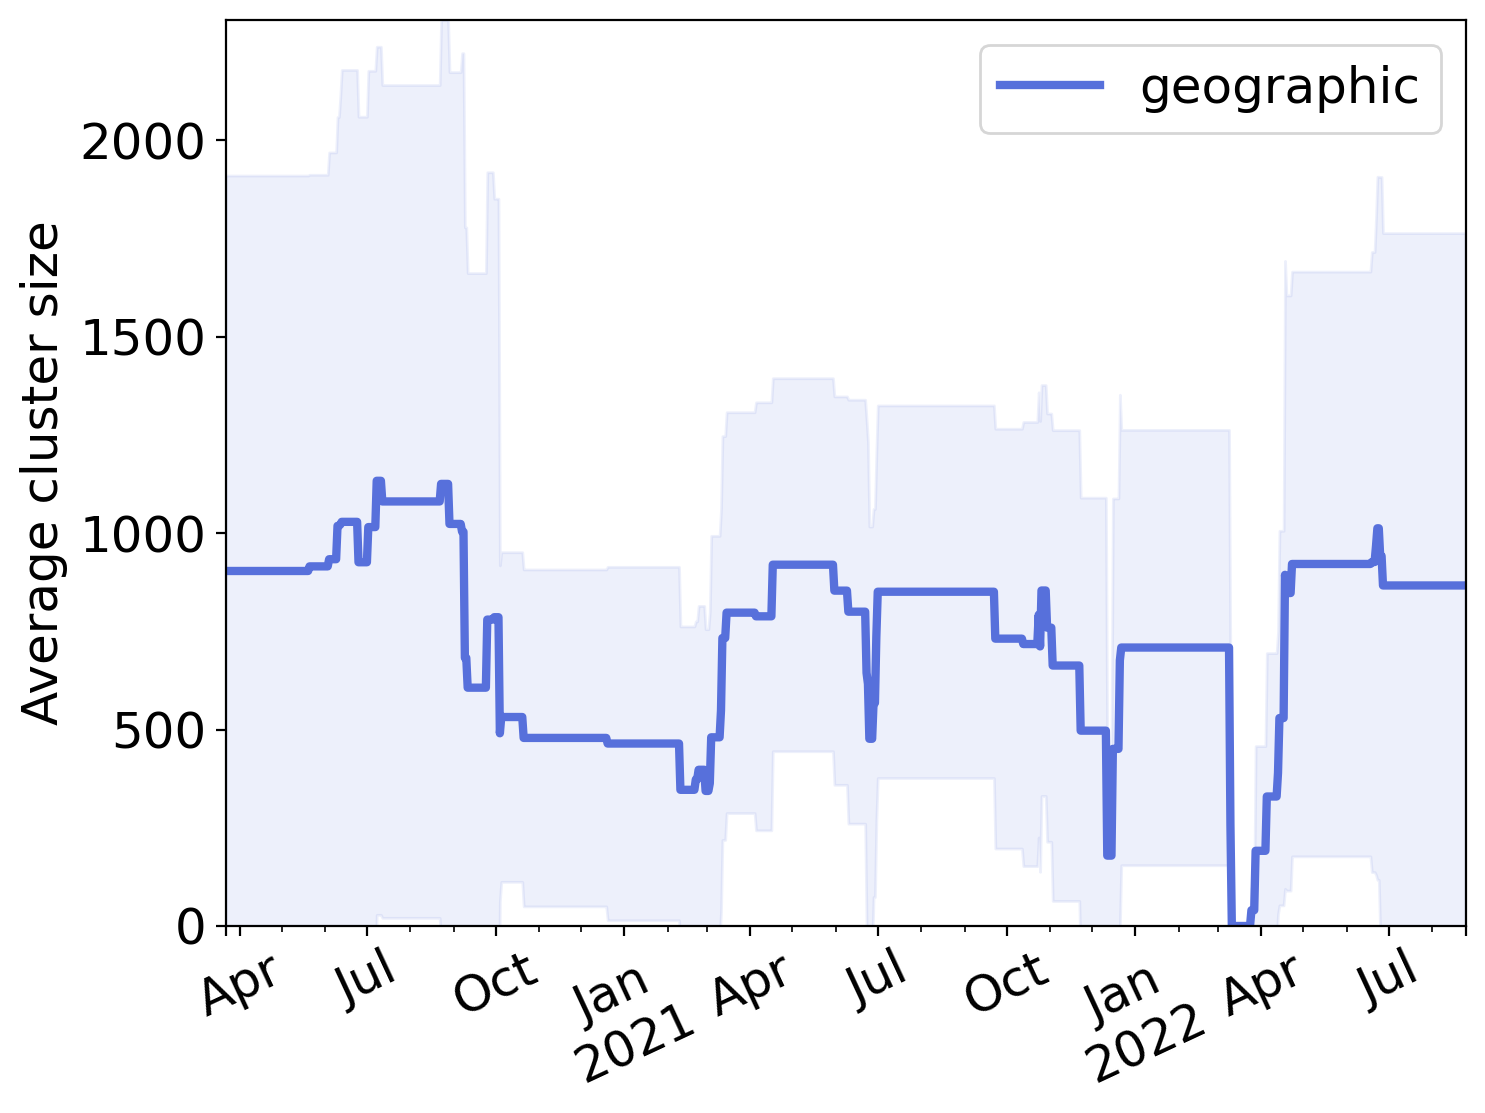

In [66]:
fig,ax = plt.subplots(figsize = (8,6), dpi = 200)
plt.rcParams.update({'font.size': 18})
var = 'geographic'
averages.loc[:,var].plot(ax = ax, c = pal[5], linewidth = 3)
ax.fill_between(data.index, averages.loc[:,var] - stds.loc[:,var], averages.loc[:,var] + stds.loc[:,var], color=pal[5], alpha=0.1)

ax.set_xlabel('')
ax.set_ylabel('Average cluster size')
ax.set_ylim(0, (averages.loc[:,var] + stds.loc[:,var]).max())
plt.xticks(rotation=25) 
plt.legend()

### Containment Health

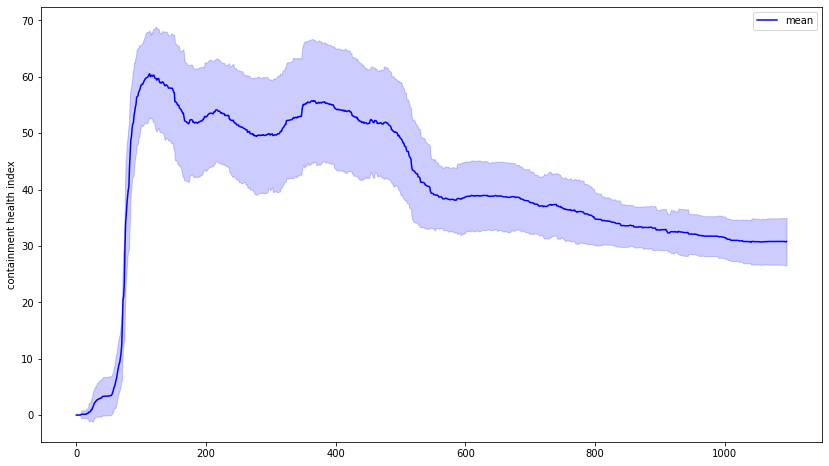

In [75]:
fig,ax = plt.subplots(figsize = (14,8))
x = range(len(containment_health.index))
mean = containment_health.mean(axis = 1)
std = containment_health.std(axis = 1)

ax.plot(x, mean, 'b-', label='mean')
ax.fill_between(x, mean - std, mean + std, color=pal[4], alpha=0.2)
ax.set_ylabel('containment health index')
pos = [0,200,400,600,800,1000]
#ax.set_xticks(pos, [containment_health.index[i] for i in pos])
plt.legend()
plt.show()

In [76]:
health_segments = []
for seg in wpool.key_list:
    dname = seg[:5]
    times = wpool.times[seg]
    loc = containment_health.loc[:,dname]
    seg_loc = loc[times[0]:times[1]]
    health_segments.append(seg_loc.mean())

Text(0.5, 0, 'Containment Health Score')

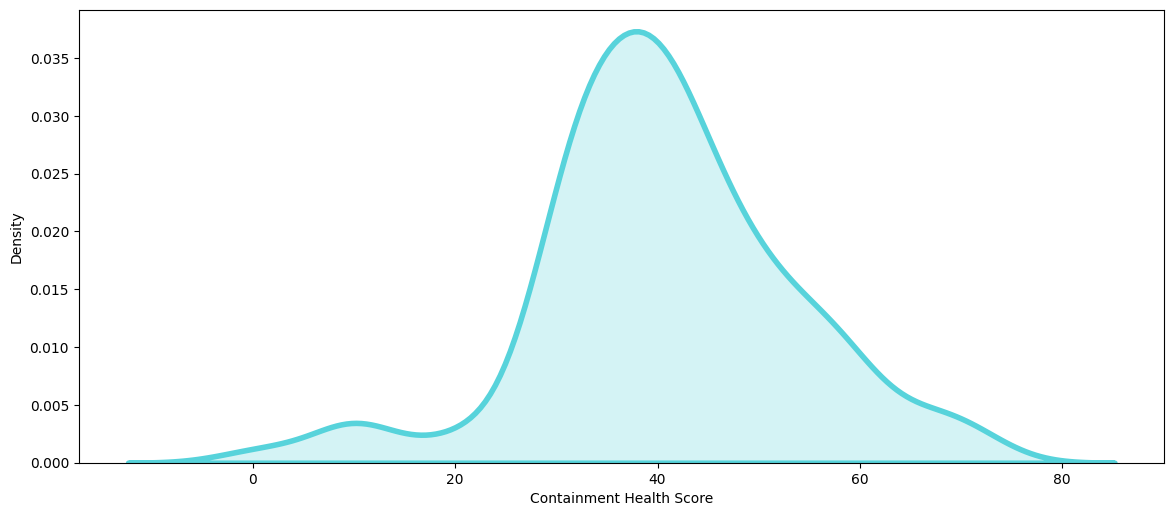

In [77]:
fig,ax = plt.subplots(figsize = (14,6), dpi = 100)
pal = sns.color_palette("hls", 8)
sns.kdeplot(health_segments, color = pal[4], linewidth = 4, fill = True)
ax.set_xlabel('Containment Health Score')